In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pygmt
from obspy.core import UTCDateTime

In [2]:
# Read in features, look at names & datatypes
df_original = pd.read_csv('p_features.csv', dtype={'location_code': str})
print(len(df_original))
print(df_original.dtypes)

72952
arrival_identifier                int64
avg_noise_1.00                  float64
avg_noise_10.00                 float64
avg_noise_11.00                 float64
avg_noise_12.00                 float64
avg_noise_13.00                 float64
avg_noise_14.00                 float64
avg_noise_15.00                 float64
avg_noise_16.00                 float64
avg_noise_17.00                 float64
avg_noise_18.00                 float64
avg_noise_2.00                  float64
avg_noise_3.00                  float64
avg_noise_4.00                  float64
avg_noise_5.00                  float64
avg_noise_6.00                  float64
avg_noise_7.00                  float64
avg_noise_8.00                  float64
avg_noise_9.00                  float64
avg_signal_1.00                 float64
avg_signal_10.00                float64
avg_signal_11.00                float64
avg_signal_12.00                float64
avg_signal_13.00                float64
avg_signal_14.00                fl

In [3]:
# This catalog of events seems to be missing 2 events 60055267, 60071327
# ngb_event_df = pd.read_csv("NGB_events_201309_201407.csv")
# ngb_event_df

# df_ngb_old = df_original[np.isin(df_original.event_identifier, ngb_event_df.evid)]

In [4]:
# Get metadata for 1 and 3c stations
eq_meta_onec = pd.read_csv("../currentEarthquakeArrivalInformation1CWithGains.csv")
eq_meta_threec = pd.read_csv("../currentEarthquakeArrivalInformation3CWithGains.csv")
eq_meta_all = pd.concat([eq_meta_onec, eq_meta_threec])

# Reduce to just location information
all_eq_locs = eq_meta_all.drop_duplicates("evid")[["evid", "event_lat", "event_lon", "origin_time"]]
all_eq_locs.columns = ["event_identifier", "event_lat", "event_lon", "origin_time"]

# Reduce to events in the dataset 
eq_locs_df = all_eq_locs[np.isin(all_eq_locs.event_identifier, df_original.event_identifier.unique())]
# Make date column for filtering
eq_locs_df.loc[:, "date"] = eq_locs_df.origin_time.apply(lambda x: int(UTCDateTime(x).strftime("%y%m%d")))

/tmp/ipykernel_24005/187499698.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  eq_meta_threec = pd.read_csv("../currentEarthquakeArrivalInformation3CWithGains.csv")
/tmp/ipykernel_24005/187499698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eq_locs_df.loc[:, "date"] = eq_locs_df.origin_time.apply(lambda x: int(UTCDateTime(x).strftime("%y%m%d")))


In [5]:
# Set filter bounds
lat_min = 44.680
lat_max = 44.870
lon_max = 110.850
lon_min = 110.640
date_min = 130901  # YYMMDD
date_max = 140630  # YYMMDD
bounds = {"lat_min": lat_min,
          "lat_max": lat_max,
          "lon_max": lon_max,
          "lon_min": lon_min,
          "date_min": date_min,
          "date_max": date_max}

# Get ngb event ids
ngb_event_locs = eq_locs_df.loc[
        (eq_locs_df["date"] >= bounds["date_min"]) & (eq_locs_df["date"] <= bounds["date_max"]) & (eq_locs_df["event_lat"] >= bounds["lat_min"])
        & (eq_locs_df["event_lat"] <= bounds["lat_max"]) & (-1 * eq_locs_df["event_lon"] >= bounds["lon_min"]) & (
                    -1 * eq_locs_df["event_lon"] <= bounds["lon_max"])]

In [6]:
df_ngb_removed = df_original[~np.isin(df_original.event_identifier, ngb_event_locs.event_identifier)]
df_ngb = df_original[np.isin(df_original.event_identifier, ngb_event_locs.event_identifier)]
np.where(np.isin(df_ngb_removed.event_identifier, df_ngb.event_identifier))

(array([], dtype=int64),)

In [7]:
# Read in park and caldera boundaries
utahnet_path = "../../maps/utahnet"
ys_border = pd.read_csv(f"{utahnet_path}/yell.border.g", delimiter=" ", names=["Longitude", "Latitude"], dtype=np.float64)
caldera = pd.read_csv(f"{utahnet_path}/caldera.ys", sep="\s+", names=["Latitude", "Longitude"], dtype=np.float64)

caldera = caldera.drop(caldera[caldera["Longitude"]==0].index)
caldera = caldera[["Longitude", "Latitude"]]
caldera["Longitude"] = caldera["Longitude"]*-1

In [8]:
# Lat/lon bounding box I could use to scale the source locations
bb_lat_min = ys_border.Latitude.min() - 0.2
bb_lat_max = ys_border.Latitude.max()
bb_lon_min = ys_border.Longitude.min() - 0.15
bb_lon_max = ys_border.Longitude.max()
ys_bb = [[bb_lon_max, bb_lat_max], [bb_lon_max, bb_lat_min], [bb_lon_min, bb_lat_min], [bb_lon_min, bb_lat_max], [bb_lon_max, bb_lat_max]]

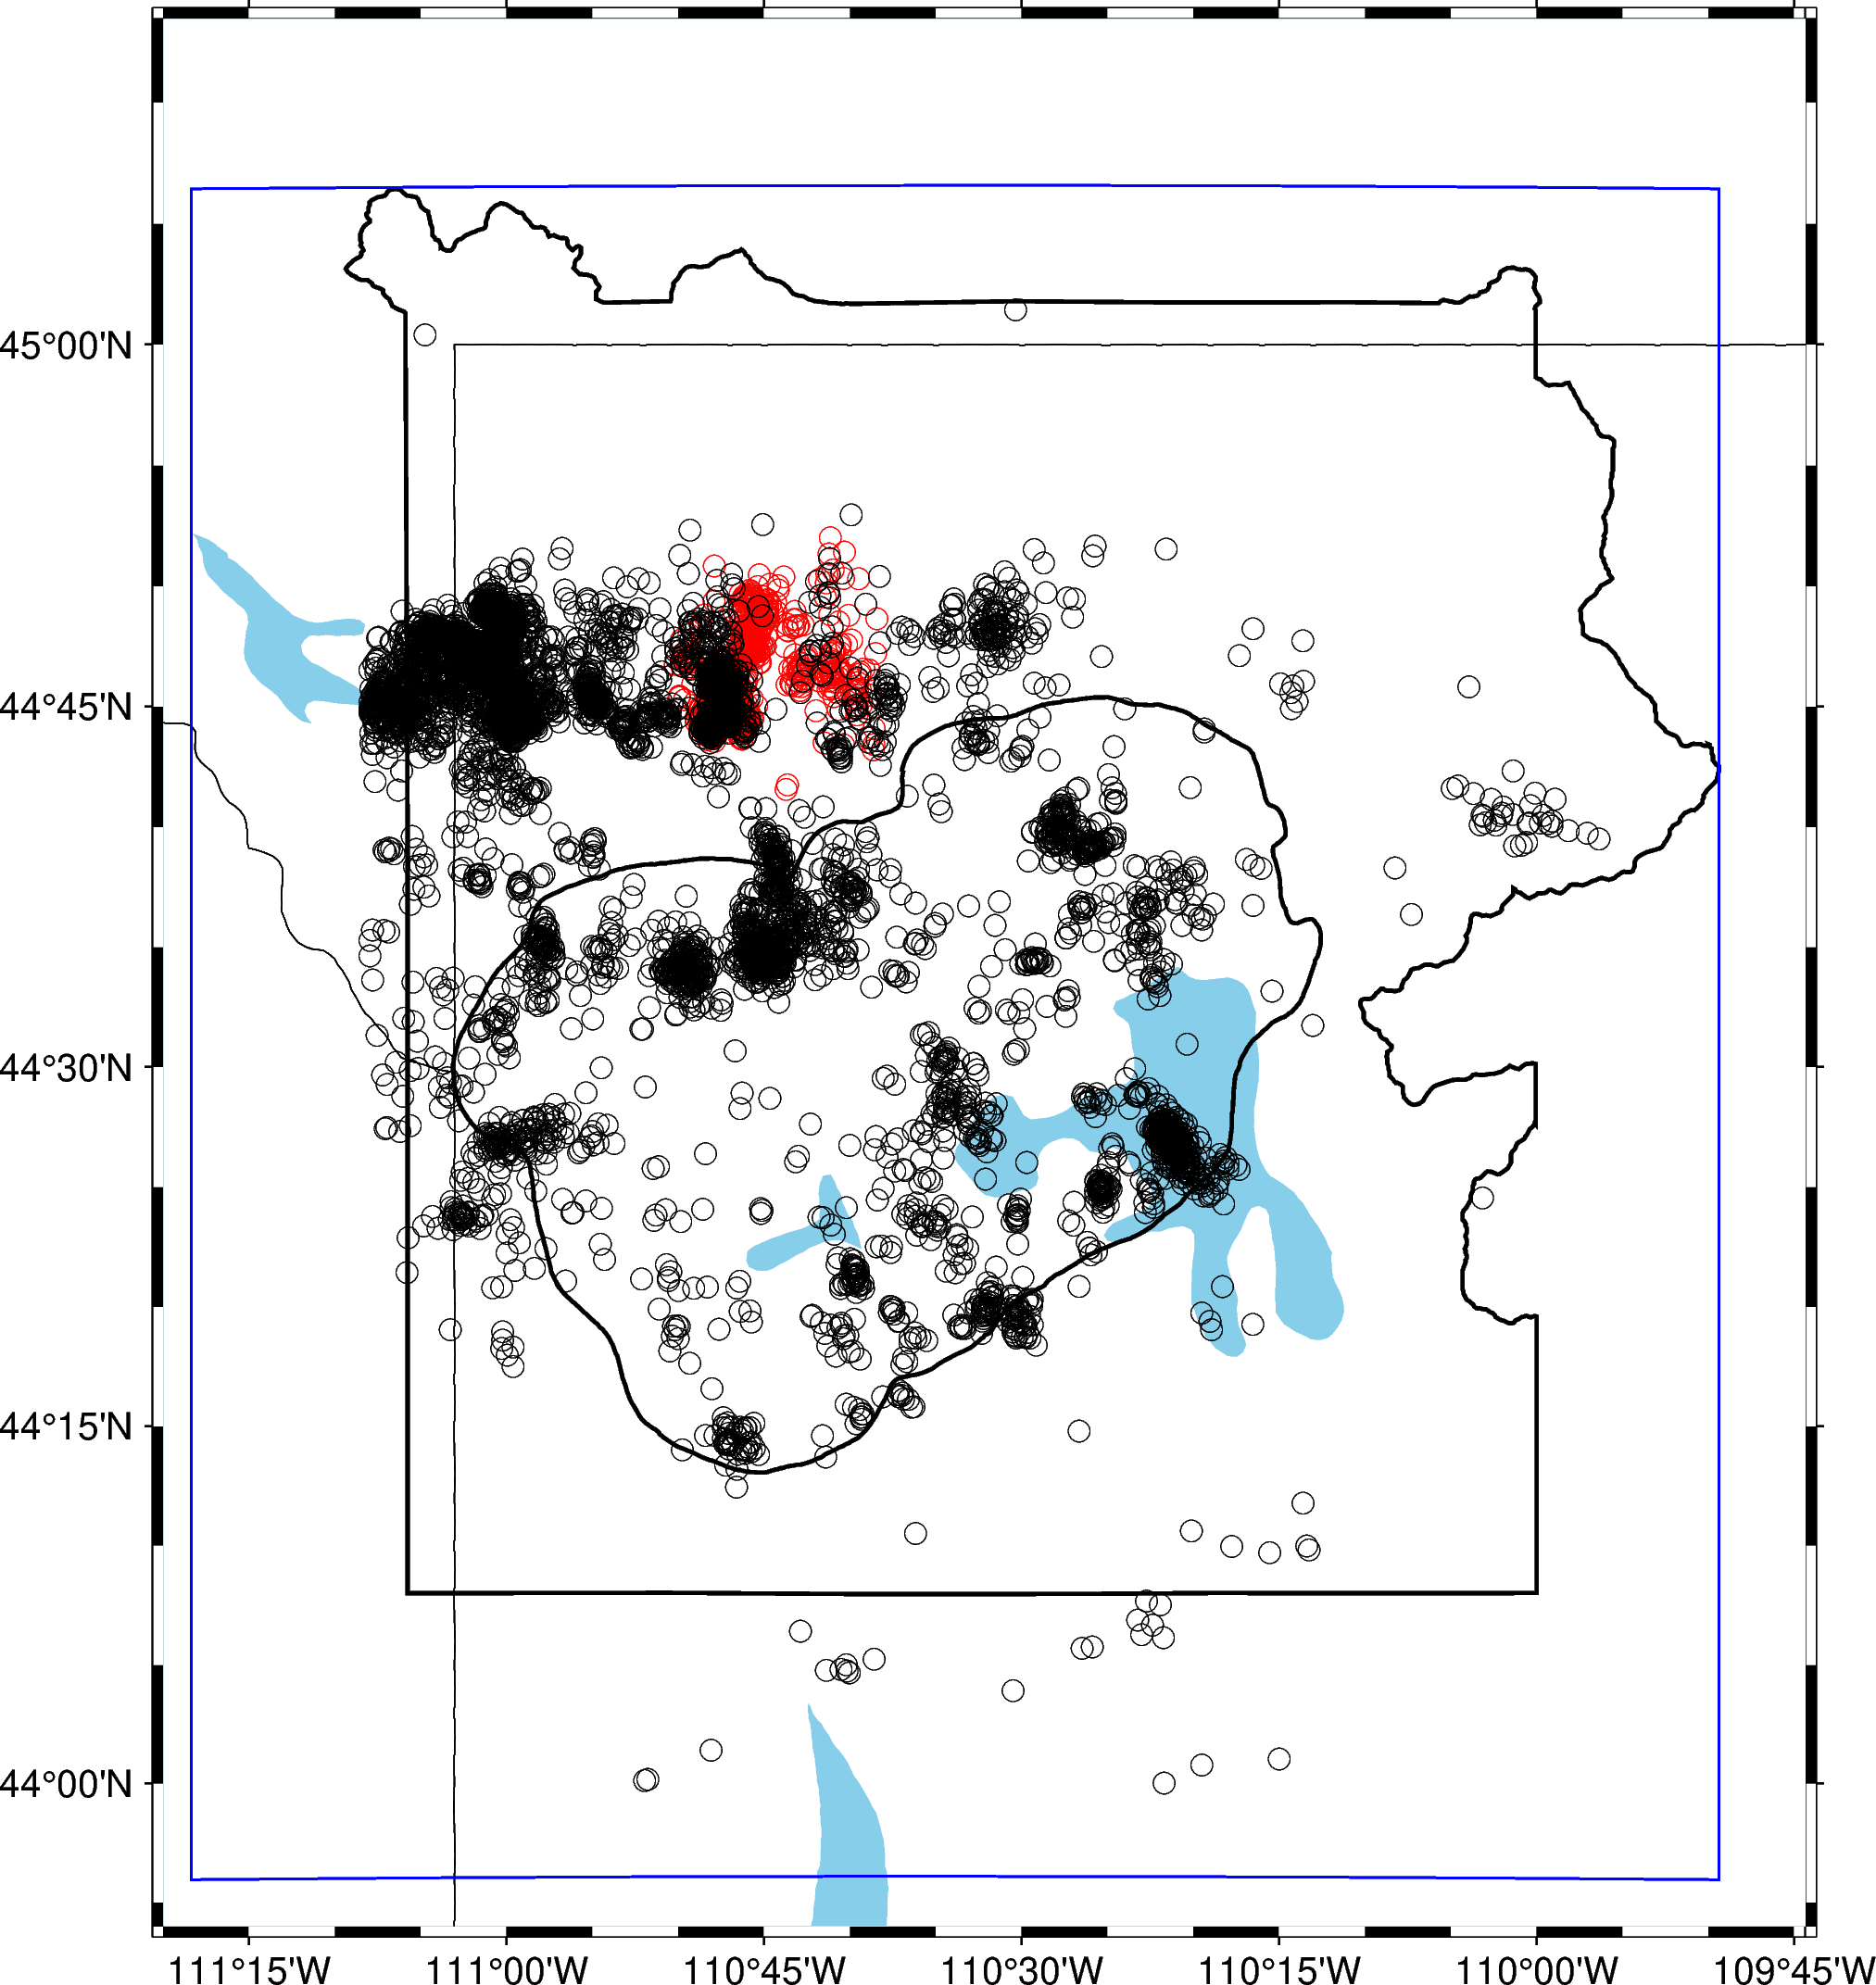

In [9]:
#Draw event map 
region = [
    eq_locs_df.event_lon.min() - 0.2,
    eq_locs_df.event_lon.max() + 0.2,
    eq_locs_df.event_lat.min() - 0.1,
    eq_locs_df.event_lat.max() + 0.2,
]

unique_locations = df_ngb_removed[["source_longitude", "source_latitude"]].drop_duplicates()
unique_ngb_locations = df_ngb[["source_longitude", "source_latitude"]].drop_duplicates()

fig = pygmt.Figure()
fig.basemap(region=region, projection="M15c", frame=True)
fig.coast(land="white", borders=2, water="skyblue")
fig.plot(data=ys_border, pen="1.0p,black")
fig.plot(data=caldera, pen='1.0p,black')
fig.plot(x=unique_ngb_locations.source_longitude, y=unique_ngb_locations.source_latitude, style="c0.2c", pen="0.2p,red")
fig.plot(x=unique_locations.source_longitude, y=unique_locations.source_latitude, style="c0.2c", pen="0.2p,black")
fig.plot(ys_bb, pen="0.6p,blue")
fig.show()

In [10]:
# Keep stations with more than 350 observations - lose 2 stations when removing NGB events (YPK and B945)
stat_counts = df_ngb_removed.value_counts("station").to_frame().reset_index()
stat_counts.columns = ["Station", "Count"]
df_org_filtcounts = df_ngb_removed[np.isin(df_ngb_removed.station, stat_counts[stat_counts.Count >= 350])]

In [11]:
stat_counts[stat_counts.Station == "B208"]

,Station,Count
26,B208,513


## Feature selection?

In [12]:
# Make train and test datasets

test_size = 0.2
station = "B208"

station_df = df_org_filtcounts[df_org_filtcounts.station == station]

evids = np.unique(station_df.event_identifier)
train_evids, test_evids = train_test_split(evids, test_size = test_size, random_state = 843823)

train_inds = np.isin(station_df.event_identifier, train_evids)
train_df = station_df[train_inds]
test_df = station_df[~train_inds]

assert len(train_df.event_identifier.unique()) == len(train_evids)
assert len(test_df.event_identifier.unique()) == len(test_evids)
assert len(test_df) + len(train_df) == len(station_df)

In [13]:
# Computes the feature matrix from a dataframe
def compute_feature_df(df, scaler = True):
    # Loosely speaking empirical magnitudes look like:
    # M = log10(A) + Q(Delta) 
    # where A is the amplitude and Q a distance dependent correction term.
    # Additionally, the difference between log10 and log amounts to a scalar
    # that a machine can learn.
    # Basically, I'm interested in features that:
    #   (1) Measure size in, potentially, different amplitudes.
    # different `passbands' deviates from the noise, 
    n_rows = len(df)
    n_columns = 48
    X = np.zeros([n_rows, n_columns])
    # Get a proxy on size
    
    # These are effectively amplitude ratios.  Note,
    # log(a/b) = log(a) - log(b)
    X[:,0]  = np.log(df['avg_signal_1.00']) - np.log(df['avg_noise_1.00'])
    X[:,1]  = np.log(df['avg_signal_2.00']) - np.log(df['avg_noise_2.00'])
    X[:,2]  = np.log(df['avg_signal_3.00']) - np.log(df['avg_noise_3.00'])
    X[:,3]  = np.log(df['avg_signal_4.00']) - np.log(df['avg_noise_4.00'])
    X[:,4]  = np.log(df['avg_signal_5.00']) - np.log(df['avg_noise_5.00'])
    X[:,5]  = np.log(df['avg_signal_6.00']) - np.log(df['avg_noise_6.00'])
    X[:,6]  = np.log(df['avg_signal_7.00']) - np.log(df['avg_noise_7.00'])
    X[:,7]  = np.log(df['avg_signal_8.00']) - np.log(df['avg_noise_8.00'])
    X[:,8]  = np.log(df['avg_signal_9.00']) - np.log(df['avg_noise_9.00'])
    X[:,9]  = np.log(df['avg_signal_10.00']) - np.log(df['avg_noise_10.00'])
    X[:,10] = np.log(df['avg_signal_11.00']) - np.log(df['avg_noise_11.00'])
    X[:,11] = np.log(df['avg_signal_12.00']) - np.log(df['avg_noise_12.00'])
    X[:,12] = np.log(df['avg_signal_13.00']) - np.log(df['avg_noise_13.00'])
    X[:,13] = np.log(df['avg_signal_14.00']) - np.log(df['avg_noise_14.00'])
    X[:,14] = np.log(df['avg_signal_15.00']) - np.log(df['avg_noise_15.00'])
    X[:,15] = np.log(df['avg_signal_16.00']) - np.log(df['avg_noise_16.00'])
    X[:,16] = np.log(df['avg_signal_17.00']) - np.log(df['avg_noise_17.00'])
    X[:,17] = np.log(df['avg_signal_18.00']) - np.log(df['avg_noise_18.00'])
    # Look at amplitudes
    X[:,18] = np.log(df['avg_signal_1.00']) 
    X[:,19] = np.log(df['avg_signal_2.00']) 
    X[:,20] = np.log(df['avg_signal_3.00']) 
    X[:,21] = np.log(df['avg_signal_4.00']) 
    X[:,22] = np.log(df['avg_signal_5.00'])
    X[:,23] = np.log(df['avg_signal_6.00'])
    X[:,24] = np.log(df['avg_signal_7.00'])
    X[:,25] = np.log(df['avg_signal_8.00'])
    X[:,26] = np.log(df['avg_signal_9.00'])
    X[:,27] = np.log(df['avg_signal_10.00'])
    X[:,28] = np.log(df['avg_signal_11.00'])
    X[:,29] = np.log(df['avg_signal_12.00'])
    X[:,30] = np.log(df['avg_signal_13.00'])
    X[:,31] = np.log(df['avg_signal_14.00'])
    X[:,32] = np.log(df['avg_signal_15.00'])
    X[:,33] = np.log(df['avg_signal_16.00'])
    X[:,34] = np.log(df['avg_signal_17.00'])
    X[:,35] = np.log(df['avg_signal_18.00'])
    # Frequency and max amplitude
    X[:,36] = np.log(df['signal_dominant_frequency'])
    X[:,37] = np.log(df['signal_dominant_amplitude'])
    # Time-based featuers: Look at max amplitudes of noise/signal
    X[:,38] = np.log(df['noise_maximum_value']  - df['noise_minimum_value'])
    X[:,39] = np.log(df['signal_maximum_value'] - df['signal_minimum_value'])
    X[:,40] = np.log(df['signal_variance'])
    X[:,41] = np.log(df['noise_variance'])
    # Source/recv distance (take log to flatten this)
    X[:,42] = np.log(df['source_receiver_distance_km'])
    X[:,43] = df['source_depth_km']
    # Single stations can learn location
    X[:,44] = df['source_latitude']
    X[:,45] = df['source_longitude']
    X[:,46] = np.sin(df['source_receiver_back_azimuth'])
    X[:,47] = df['source_receiver_back_azimuth']

    
    # Standardize features
    if (scaler):
        scaler = StandardScaler()
        scaler = scaler.fit(X)
        X = scaler.transform(X)
        return X, scaler
    
    return X
    
#X, scaler = compute_feature_matrix(df)

In [14]:
train_feat_matrix_scaled, scaler = compute_feature_df(train_df)
train_feat_matrix_unscaled = compute_feature_df(train_df, scaler=False)

train_y = train_df.magnitude.values

In [15]:
train_feat_matrix_scaled[0], train_feat_matrix_unscaled[0]

(array([ 1.37799911,  0.99581247, -0.12597027, -0.35563096, -0.52227232,
        -0.91949519, -1.0903427 , -1.10752313, -1.27476239, -1.41432806,
        -1.48795245, -1.51781274, -1.5265889 , -1.52475287, -1.50754226,
        -1.47892056, -1.44526535, -1.40910845,  0.60066611, -0.11074152,
        -0.64348082, -0.50311957, -0.54415501, -0.7133212 , -0.79695914,
        -0.78637718, -0.81061393, -0.86454007, -0.93025056, -0.99995612,
        -1.0666898 , -1.12380731, -1.16683864, -1.19663688, -1.21674063,
        -1.22826749, -2.41638783, -0.44386845, -0.07215975, -0.60398884,
        -0.46245863, -0.26099892,  1.37927798,  3.36617858, -1.20642467,
        -2.07060799, -1.36438504, -0.12494186]),
 array([   3.20592077,    3.27737116,    2.57552289,    2.59786938,
           2.51538357,    2.35329026,    2.51000679,    2.69148906,
           2.5654322 ,    2.3641488 ,    2.19082056,    2.05898701,
           1.95636036,    1.87436431,    1.82297366,    1.79923992,
           1.79515106,

In [16]:
train_y

array([2.06, 3.16, 2.76, 2.08, 2.5 , 2.33, 2.  , 1.58, 2.02, 1.71, 2.01,
       1.43, 1.24, 1.38, 1.51, 2.62, 2.03, 1.8 , 1.2 , 1.36, 1.2 , 0.71,
       1.56, 1.27, 1.2 , 2.13, 2.07, 1.88, 1.31, 1.42, 2.18, 1.88, 1.21,
       1.44, 1.51, 2.28, 1.99, 1.38, 0.99, 1.66, 1.48, 1.13, 1.54, 0.92,
       3.27, 1.15, 1.46, 1.59, 2.25, 3.05, 1.45, 1.37, 1.46, 0.9 , 1.44,
       1.54, 1.26, 2.06, 2.83, 1.42, 2.99, 2.5 , 1.46, 0.96, 2.17, 1.73,
       1.47, 0.87, 1.84, 1.35, 0.86, 1.42, 1.76, 2.4 , 2.87, 1.78, 1.43,
       0.83, 1.4 , 1.26, 0.71, 0.82, 2.22, 1.19, 1.64, 1.07, 1.33, 1.09,
       2.72, 1.71, 2.39, 2.3 , 1.81, 1.77, 2.69, 0.58, 1.56, 0.92, 0.96,
       2.12, 1.92, 0.98, 0.78, 1.49, 1.82, 1.27, 1.52, 0.94, 0.78, 2.13,
       1.59, 1.99, 1.62, 1.63, 3.43, 2.66, 2.7 , 1.63, 1.12, 1.35, 1.24,
       1.86, 1.58, 1.18, 2.1 , 1.64, 2.48, 1.33, 1.81, 2.1 , 1.5 , 2.34,
       2.13, 1.3 , 1.62, 2.07, 1.95, 2.43, 1.77, 2.3 , 2.82, 2.48, 1.82,
       1.52, 1.28, 1.22, 1.2 , 1.38, 1.28, 1.15, 1.

In [17]:
train_feat_df = pd.DataFrame(train_feat_matrix_scaled, columns=["amp_ratio_01.0", "amp_ratio_02.0", "amp_ratio_03.0", "amp_ratio_04.0", 
                                 "amp_ratio_05.0", "amp_ratio_06.0", "amp_ratio_07.0", "amp_ratio_08.0",
                                 "amp_ratio_09.0", "amp_ratio_10.0", "amp_ratio_11.0", "amp_ratio_12.0", 
                                 "amp_ratio_13.0", "amp_ratio_14.0", "amp_ratio_15.0", "amp_ratio_16.0", 
                                 "amp_ratio_17.0", "amp_ratio_18.0", 
                                 "amp_01.0", "amp_02.0", "amp_03.0", "amp_04.0", 
                                 "amp_05.0", "amp_06.0", "amp_07.0", "amp_08.0",
                                 "amp_09.0", "amp_10.0", "amp_11.0", "amp_12.0", 
                                 "amp_13.0", "amp_14.0", "amp_15.0", "amp_16.0", 
                                 "amp_17.0", "amp_18.0",
                                 "signal_dominant_frequency", "signal_dominant_amplitude", 
                                 "noise_max_amplitude", "signal_max_amplitude", "signal_variance", "noise_variance",
                                 "source_receiver_distance_logkm", "source_depth_km","source_latitude", "source_longitude", 
                                 "sin_receiver_back_azimuth", "receiver_back_azimuth"])

In [18]:
train_feat_df_unscaled = pd.DataFrame(train_feat_matrix_unscaled, columns=["amp_ratio_01.0", "amp_ratio_02.0", "amp_ratio_03.0", "amp_ratio_04.0", 
                                 "amp_ratio_05.0", "amp_ratio_06.0", "amp_ratio_07.0", "amp_ratio_08.0",
                                 "amp_ratio_09.0", "amp_ratio_10.0", "amp_ratio_11.0", "amp_ratio_12.0", 
                                 "amp_ratio_13.0", "amp_ratio_14.0", "amp_ratio_15.0", "amp_ratio_16.0", 
                                 "amp_ratio_17.0", "amp_ratio_18.0", 
                                 "amp_01.0", "amp_02.0", "amp_03.0", "amp_04.0", 
                                 "amp_05.0", "amp_06.0", "amp_07.0", "amp_08.0",
                                 "amp_09.0", "amp_10.0", "amp_11.0", "amp_12.0", 
                                 "amp_13.0", "amp_14.0", "amp_15.0", "amp_16.0", 
                                 "amp_17.0", "amp_18.0",
                                 "signal_dominant_frequency", "signal_dominant_amplitude", 
                                 "noise_max_amplitude", "signal_max_amplitude", "signal_variance", "noise_variance",
                                 "source_receiver_distance_logkm", "source_depth_km","source_latitude", "source_longitude", 
                                 "sin_receiver_back_azimuth", "receiver_back_azimuth"])

In [19]:
feat_target_df = train_feat_df.copy()
feat_target_df.loc[:, "magnitude"] = train_y
corr = feat_target_df.corr()
corr.style.background_gradient(cmap="coolwarm")

,amp_ratio_01.0,amp_ratio_02.0,amp_ratio_03.0,amp_ratio_04.0,amp_ratio_05.0,amp_ratio_06.0,amp_ratio_07.0,amp_ratio_08.0,amp_ratio_09.0,amp_ratio_10.0,amp_ratio_11.0,amp_ratio_12.0,amp_ratio_13.0,amp_ratio_14.0,amp_ratio_15.0,amp_ratio_16.0,amp_ratio_17.0,amp_ratio_18.0,amp_01.0,amp_02.0,amp_03.0,amp_04.0,amp_05.0,amp_06.0,amp_07.0,amp_08.0,amp_09.0,amp_10.0,amp_11.0,amp_12.0,amp_13.0,amp_14.0,amp_15.0,amp_16.0,amp_17.0,amp_18.0,signal_dominant_frequency,signal_dominant_amplitude,noise_max_amplitude,signal_max_amplitude,signal_variance,noise_variance,source_receiver_distance_logkm,source_depth_km,source_latitude,source_longitude,sin_receiver_back_azimuth,receiver_back_azimuth,magnitude
amp_ratio_01.0,1.000000,0.526213,0.452010,0.407452,0.337244,0.277560,0.245287,0.223300,0.201168,0.184887,0.171394,0.159020,0.147617,0.135632,0.123828,0.112943,0.103170,0.094521,0.397856,0.213457,0.203857,0.181314,0.151106,0.129599,0.127994,0.133339,0.134606,0.131126,0.125505,0.118231,0.109970,0.101284,0.092906,0.085191,0.078302,0.072211,-0.163886,0.172963,-0.127127,0.155257,0.168495,-0.148082,0.042674,0.264793,0.067368,-0.165460,-0.025050,-0.053096,0.356660
amp_ratio_02.0,0.526213,1.000000,0.801426,0.710978,0.647775,0.599250,0.562217,0.539904,0.520958,0.508041,0.497332,0.486908,0.475863,0.462170,0.447319,0.433894,0.422640,0.413489,0.466304,0.532286,0.498308,0.472932,0.455177,0.438077,0.428902,0.427260,0.427777,0.428368,0.427659,0.425156,0.420531,0.414106,0.407019,0.400324,0.394473,0.389486,-0.114174,0.482868,-0.169798,0.460921,0.473924,-0.201466,-0.227088,0.076838,-0.060241,0.134306,-0.129839,-0.144144,0.411435
amp_ratio_03.0,0.452010,0.801426,1.000000,0.889638,0.805992,0.747496,0.694786,0.668984,0.652090,0.640133,0.630398,0.621316,0.611048,0.598626,0.585296,0.573008,0.562312,0.553293,0.542833,0.603361,0.651864,0.621493,0.601983,0.582764,0.567122,0.561465,0.560398,0.560594,0.559701,0.557003,0.552315,0.546267,0.539926,0.534012,0.528782,0.524267,-0.056201,0.614054,-0.117794,0.597957,0.605258,-0.141211,-0.378743,-0.020625,-0.127382,0.280317,-0.092970,-0.290769,0.388275
amp_ratio_04.0,0.407452,0.710978,0.889638,1.000000,0.954475,0.871042,0.808665,0.778229,0.756936,0.743239,0.734250,0.725510,0.714379,0.700906,0.687035,0.674607,0.663987,0.655113,0.606530,0.665276,0.712433,0.734157,0.719791,0.685381,0.664649,0.656995,0.654252,0.653751,0.652949,0.650398,0.645746,0.639542,0.632976,0.627010,0.621898,0.617558,-0.003470,0.698357,-0.060980,0.690564,0.697103,-0.075784,-0.474371,-0.060765,-0.152874,0.338804,-0.092262,-0.310848,0.365358
amp_ratio_05.0,0.337244,0.647775,0.805992,0.954475,1.000000,0.953325,0.889664,0.853960,0.829556,0.814307,0.805186,0.796869,0.786395,0.773699,0.760669,0.748997,0.739001,0.730594,0.605516,0.683131,0.721171,0.746835,0.755392,0.733796,0.713976,0.705276,0.701935,0.701184,0.700817,0.699391,0.696202,0.691287,0.685699,0.680462,0.675928,0.672064,0.053629,0.735159,-0.048772,0.732753,0.735623,-0.054303,-0.521611,-0.090111,-0.125305,0.403607,-0.094008,-0.281326,0.331249
amp_ratio_06.0,0.277560,0.599250,0.747496,0.871042,0.953325,1.000000,0.974057,0.939936,0.912843,0.894383,0.882561,0.872946,0.862213,0.849721,0.837062,0.825679,0.815890,0.807671,0.590869,0.683304,0.715109,0.730605,0.753964,0.767403,0.762260,0.754616,0.749961,0.747889,0.746985,0.746095,0.744238,0.740922,0.736809,0.732767,0.729135,0.725989,0.145209,0.759258,-0.055632,0.763857,0.761416,-0.054161,-0.570786,-0.117367,-0.078015,0.481039,-0.078843,-0.258484,0.281546
amp_ratio_07.0,0.245287,0.562217,0.694786,0.808665,0.889664,0.974057,1.000000,0.987138,0.963915,0.943549,0.928223,0.915318,0.902225,0.888266,0.874560,0.862260,0.851747,0.843012,0.569902,0.662320,0.687584,0.700403,0.723506,0.750123,0.760457,0.758625,0.754932,0.752150,0.750225,0.748637,0.746650,0.743702,0.740167,0.736715,0.733600,0.730897,0.198533,0.743751,-0.088100,0.752905,0.747965,-0.078624,-0.569553,-0.119215,-0.033386,0.487908,-0.057403,-0.227349,0.258312
amp_ratio_08.0,0.223300,0.539904,0.668984,0.778229,0.853960,0.9

In [20]:
from sklearn.feature_selection import mutual_info_regression, SequentialFeatureSelector, RFE

In [21]:
mutual_reg = mutual_info_regression(train_feat_matrix_scaled, train_y, random_state=843824)
mutual_reg

array([0.068616  , 0.14894487, 0.12529253, 0.1393566 , 0.13187707,
       0.15300521, 0.09950987, 0.08910805, 0.07028973, 0.09916849,
       0.11589757, 0.08967765, 0.07550259, 0.07017811, 0.0635256 ,
       0.07130777, 0.09145123, 0.05947773, 0.20454313, 0.28717855,
       0.19851386, 0.19075795, 0.23227752, 0.13337246, 0.16069397,
       0.19986572, 0.20483172, 0.22316165, 0.19248321, 0.16543422,
       0.12030699, 0.07701252, 0.0560895 , 0.06906386, 0.10751519,
       0.11293339, 0.07682536, 0.15757127, 0.037726  , 0.20926236,
       0.21504497, 0.06229106, 0.14840084, 0.10524686, 0.10085118,
       0.16749269, 0.03942481, 0.10963017])

In [22]:
train_feat_df.columns[np.argsort(mutual_reg, axis=0)]

Index(['noise_max_amplitude', 'sin_receiver_back_azimuth', 'amp_15.0',
       'amp_ratio_18.0', 'noise_variance', 'amp_ratio_15.0', 'amp_ratio_01.0',
       'amp_16.0', 'amp_ratio_14.0', 'amp_ratio_09.0', 'amp_ratio_16.0',
       'amp_ratio_13.0', 'signal_dominant_frequency', 'amp_14.0',
       'amp_ratio_08.0', 'amp_ratio_12.0', 'amp_ratio_17.0', 'amp_ratio_10.0',
       'amp_ratio_07.0', 'source_latitude', 'source_depth_km', 'amp_17.0',
       'receiver_back_azimuth', 'amp_18.0', 'amp_ratio_11.0', 'amp_13.0',
       'amp_ratio_03.0', 'amp_ratio_05.0', 'amp_06.0', 'amp_ratio_04.0',
       'source_receiver_distance_logkm', 'amp_ratio_02.0', 'amp_ratio_06.0',
       'signal_dominant_amplitude', 'amp_07.0', 'amp_12.0', 'source_longitude',
       'amp_04.0', 'amp_11.0', 'amp_03.0', 'amp_08.0', 'amp_01.0', 'amp_09.0',
       'signal_max_amplitude', 'signal_variance', 'amp_10.0', 'amp_05.0',
       'amp_02.0'],
      dtype='object')

In [23]:
# Make cross validation splits across evids

from sklearn.model_selection import KFold
evids = train_df.event_identifier.unique()
kf = KFold(n_splits=5, shuffle=True, random_state=843824)
folds = []
for train_index, test_index in kf.split(evids):
    # Get the evids corresponding to the split indicies
    fold_train_evids = evids[train_index]
    fold_test_evids = evids[test_index]
    # Get rows of training dataset that correspond to split evids
    fold_train_inds = np.where(np.isin(train_df.event_identifier, fold_train_evids))[0]
    fold_test_inds = np.where(np.isin(train_df.event_identifier, fold_test_evids))[0]
    
    folds.append((fold_train_inds, fold_test_inds))

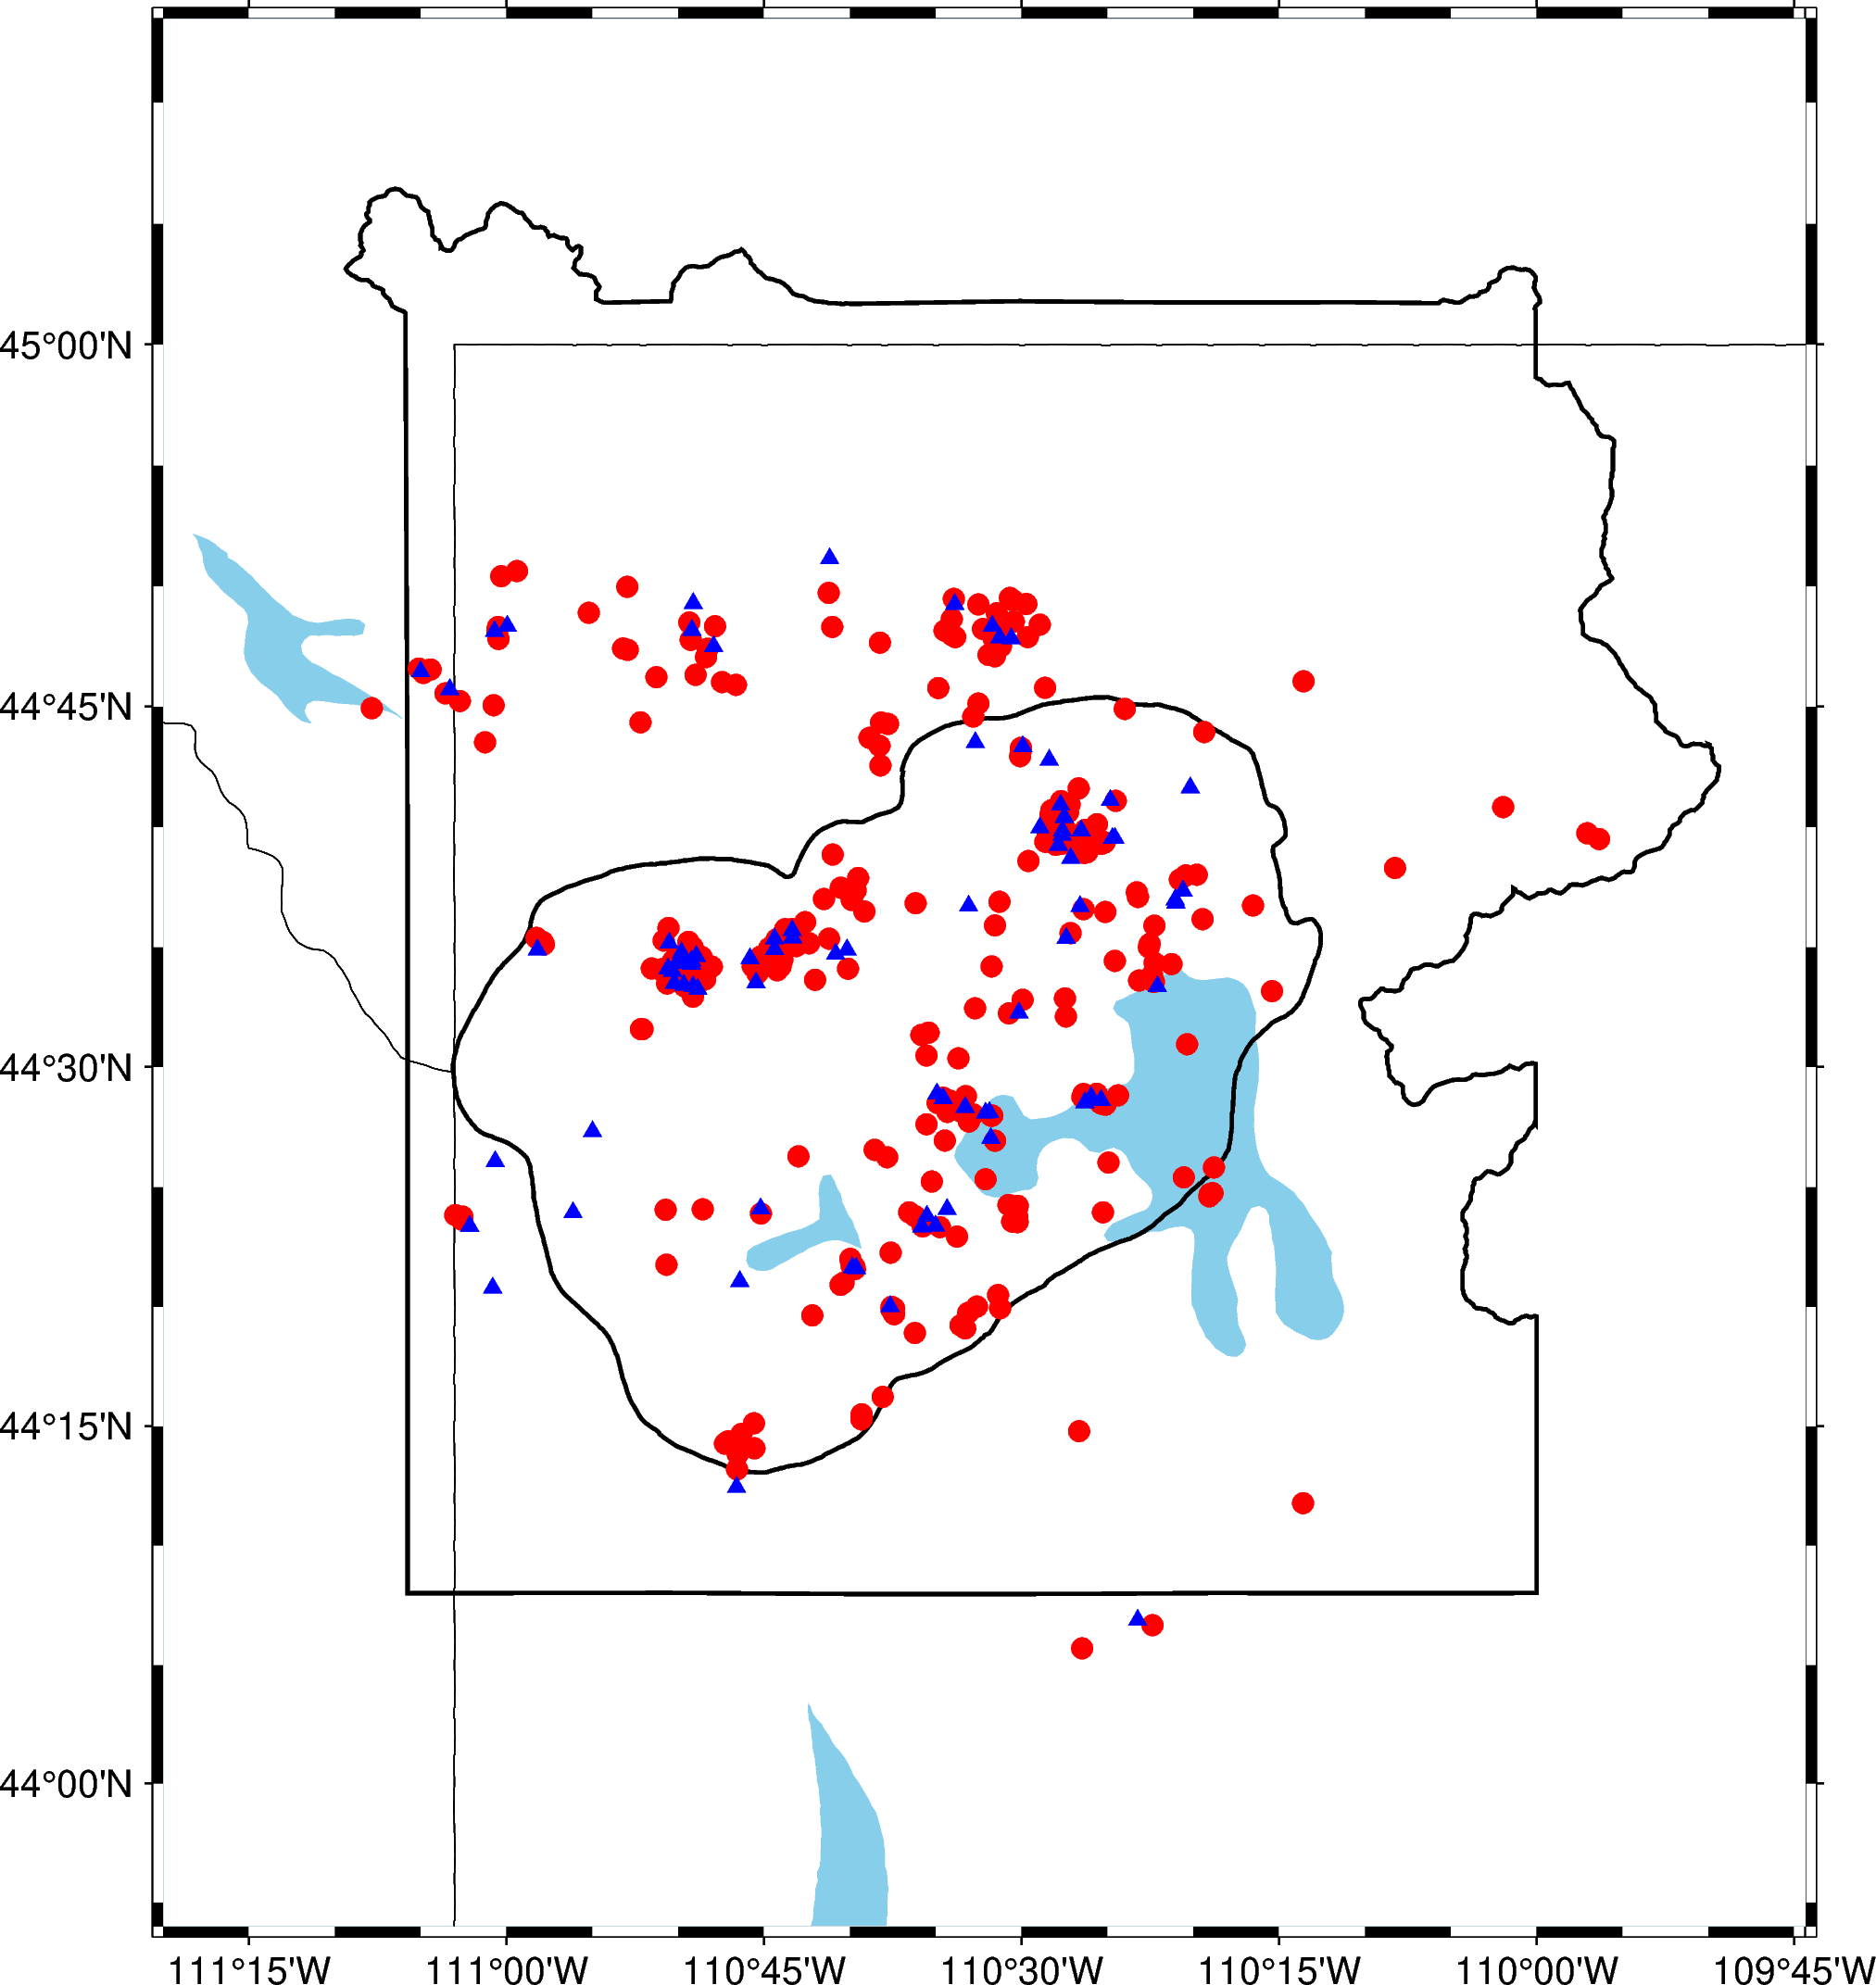

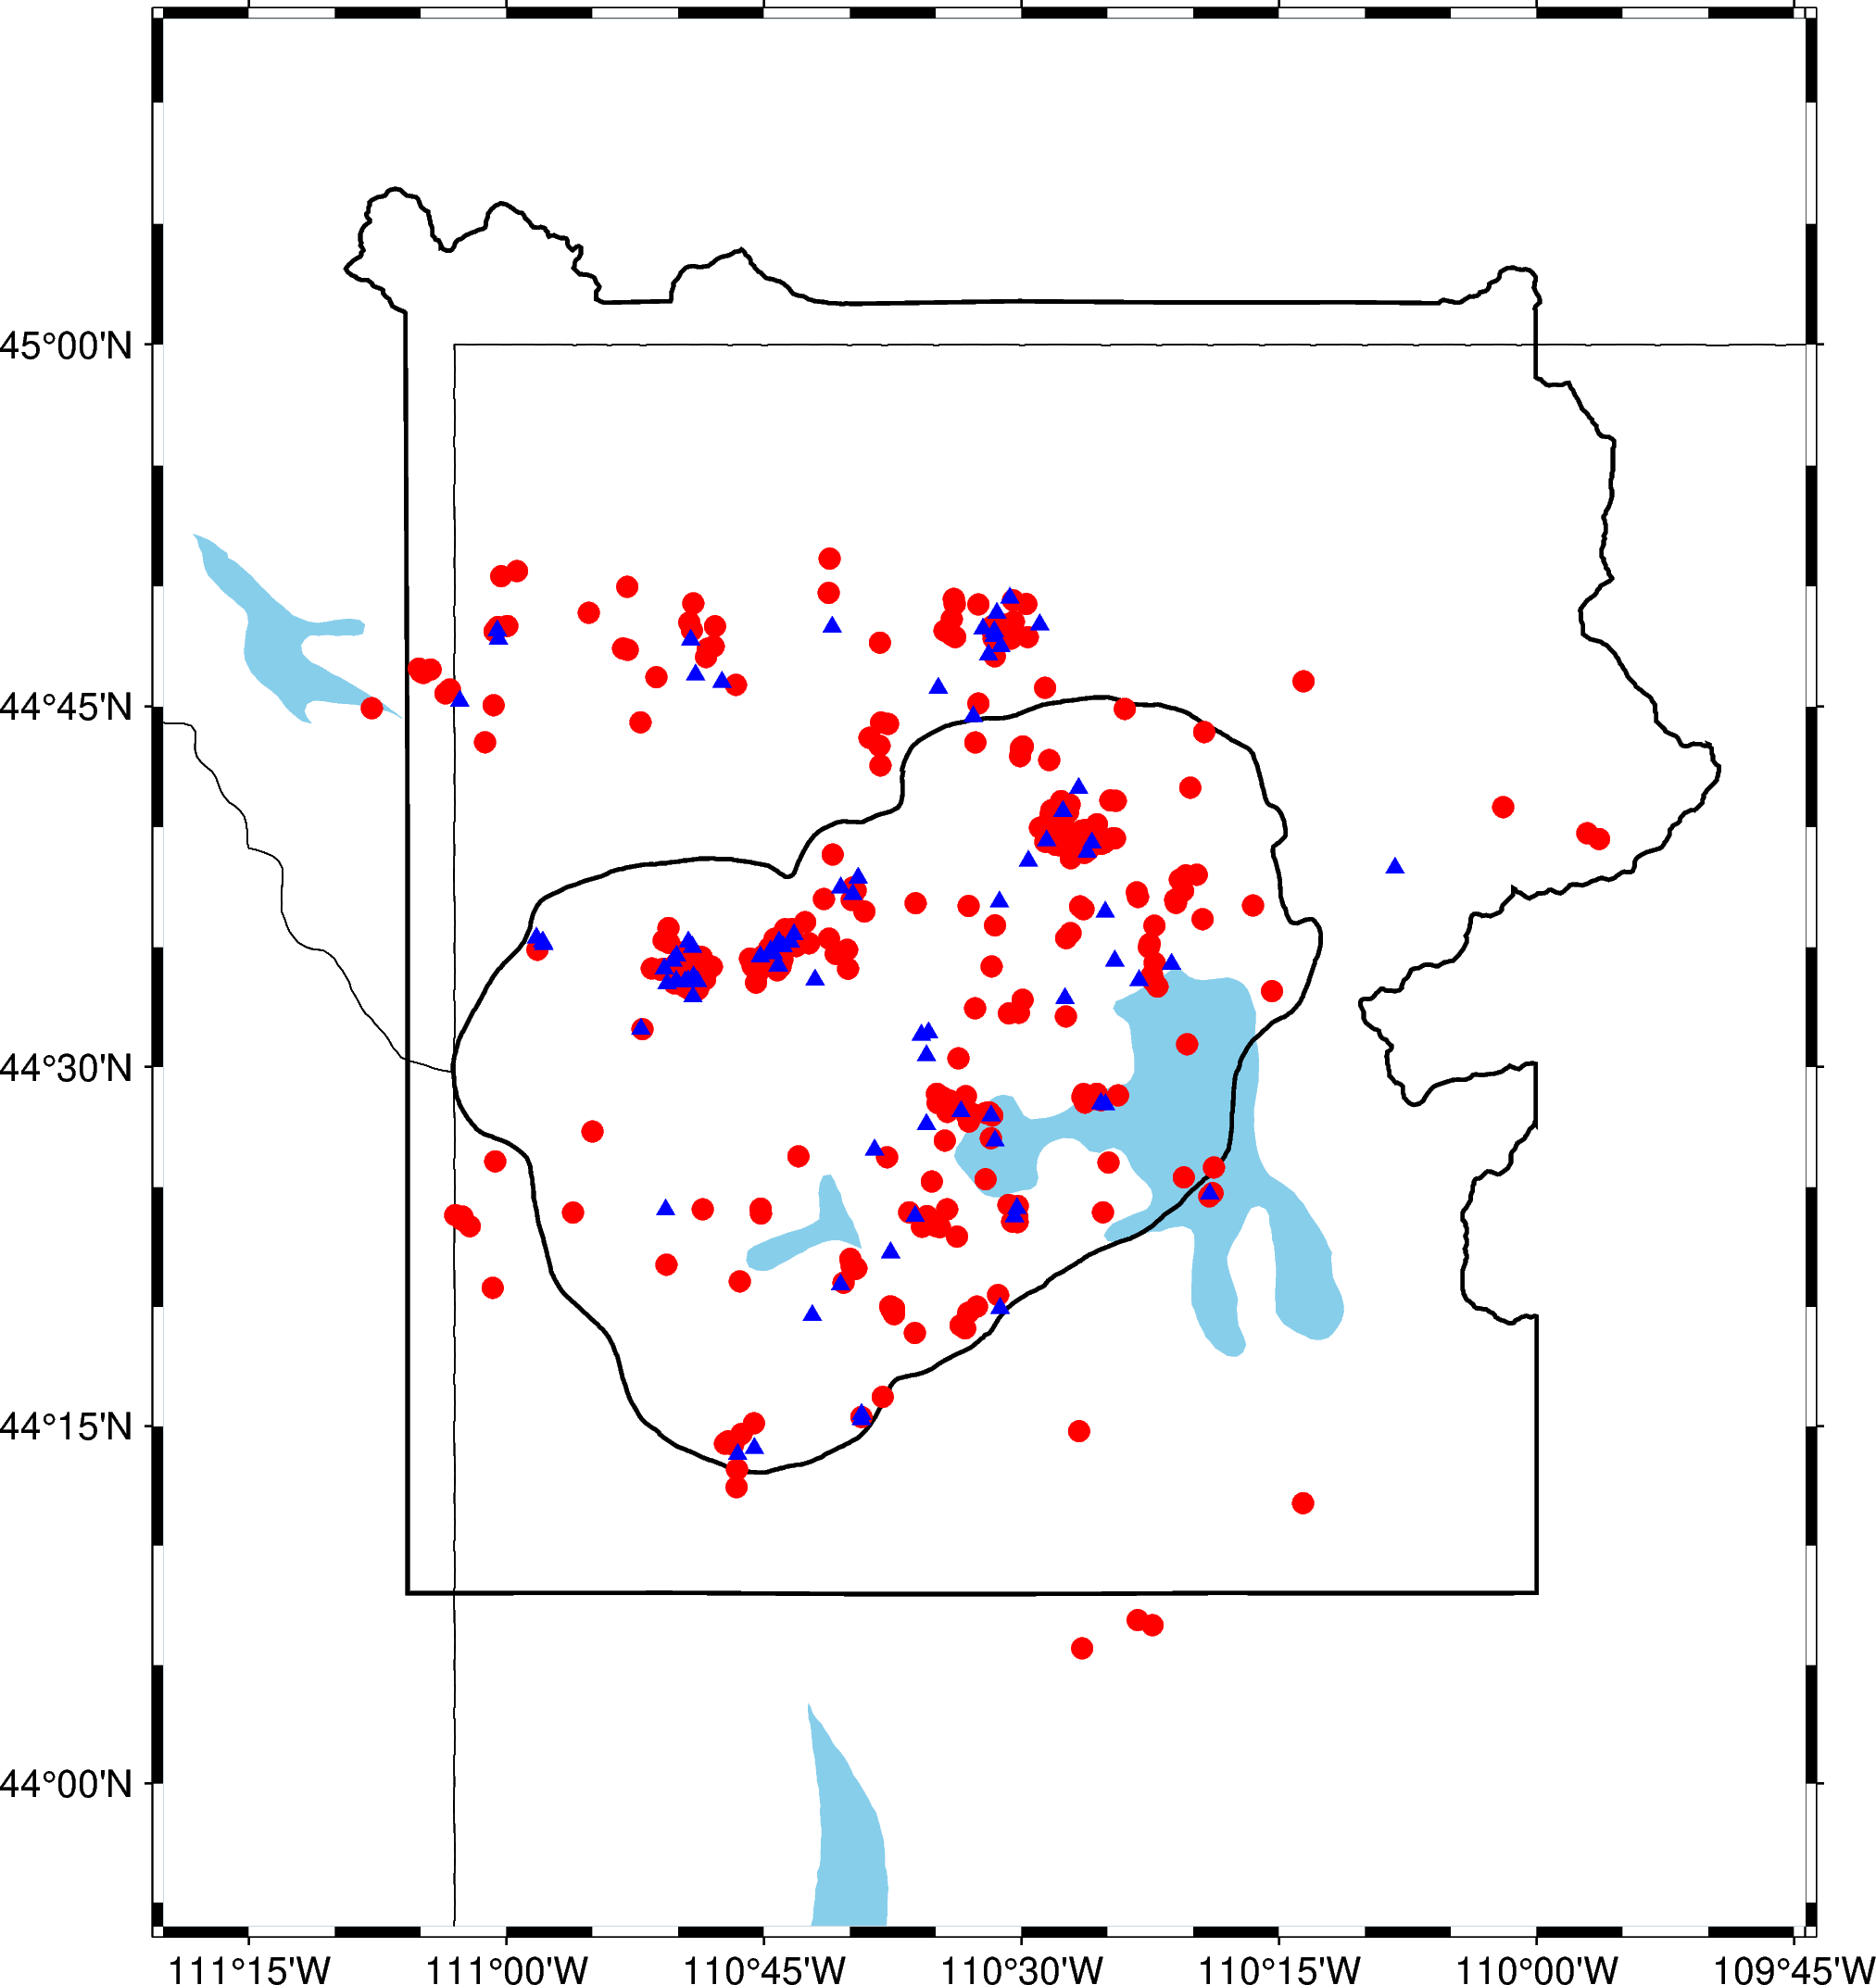

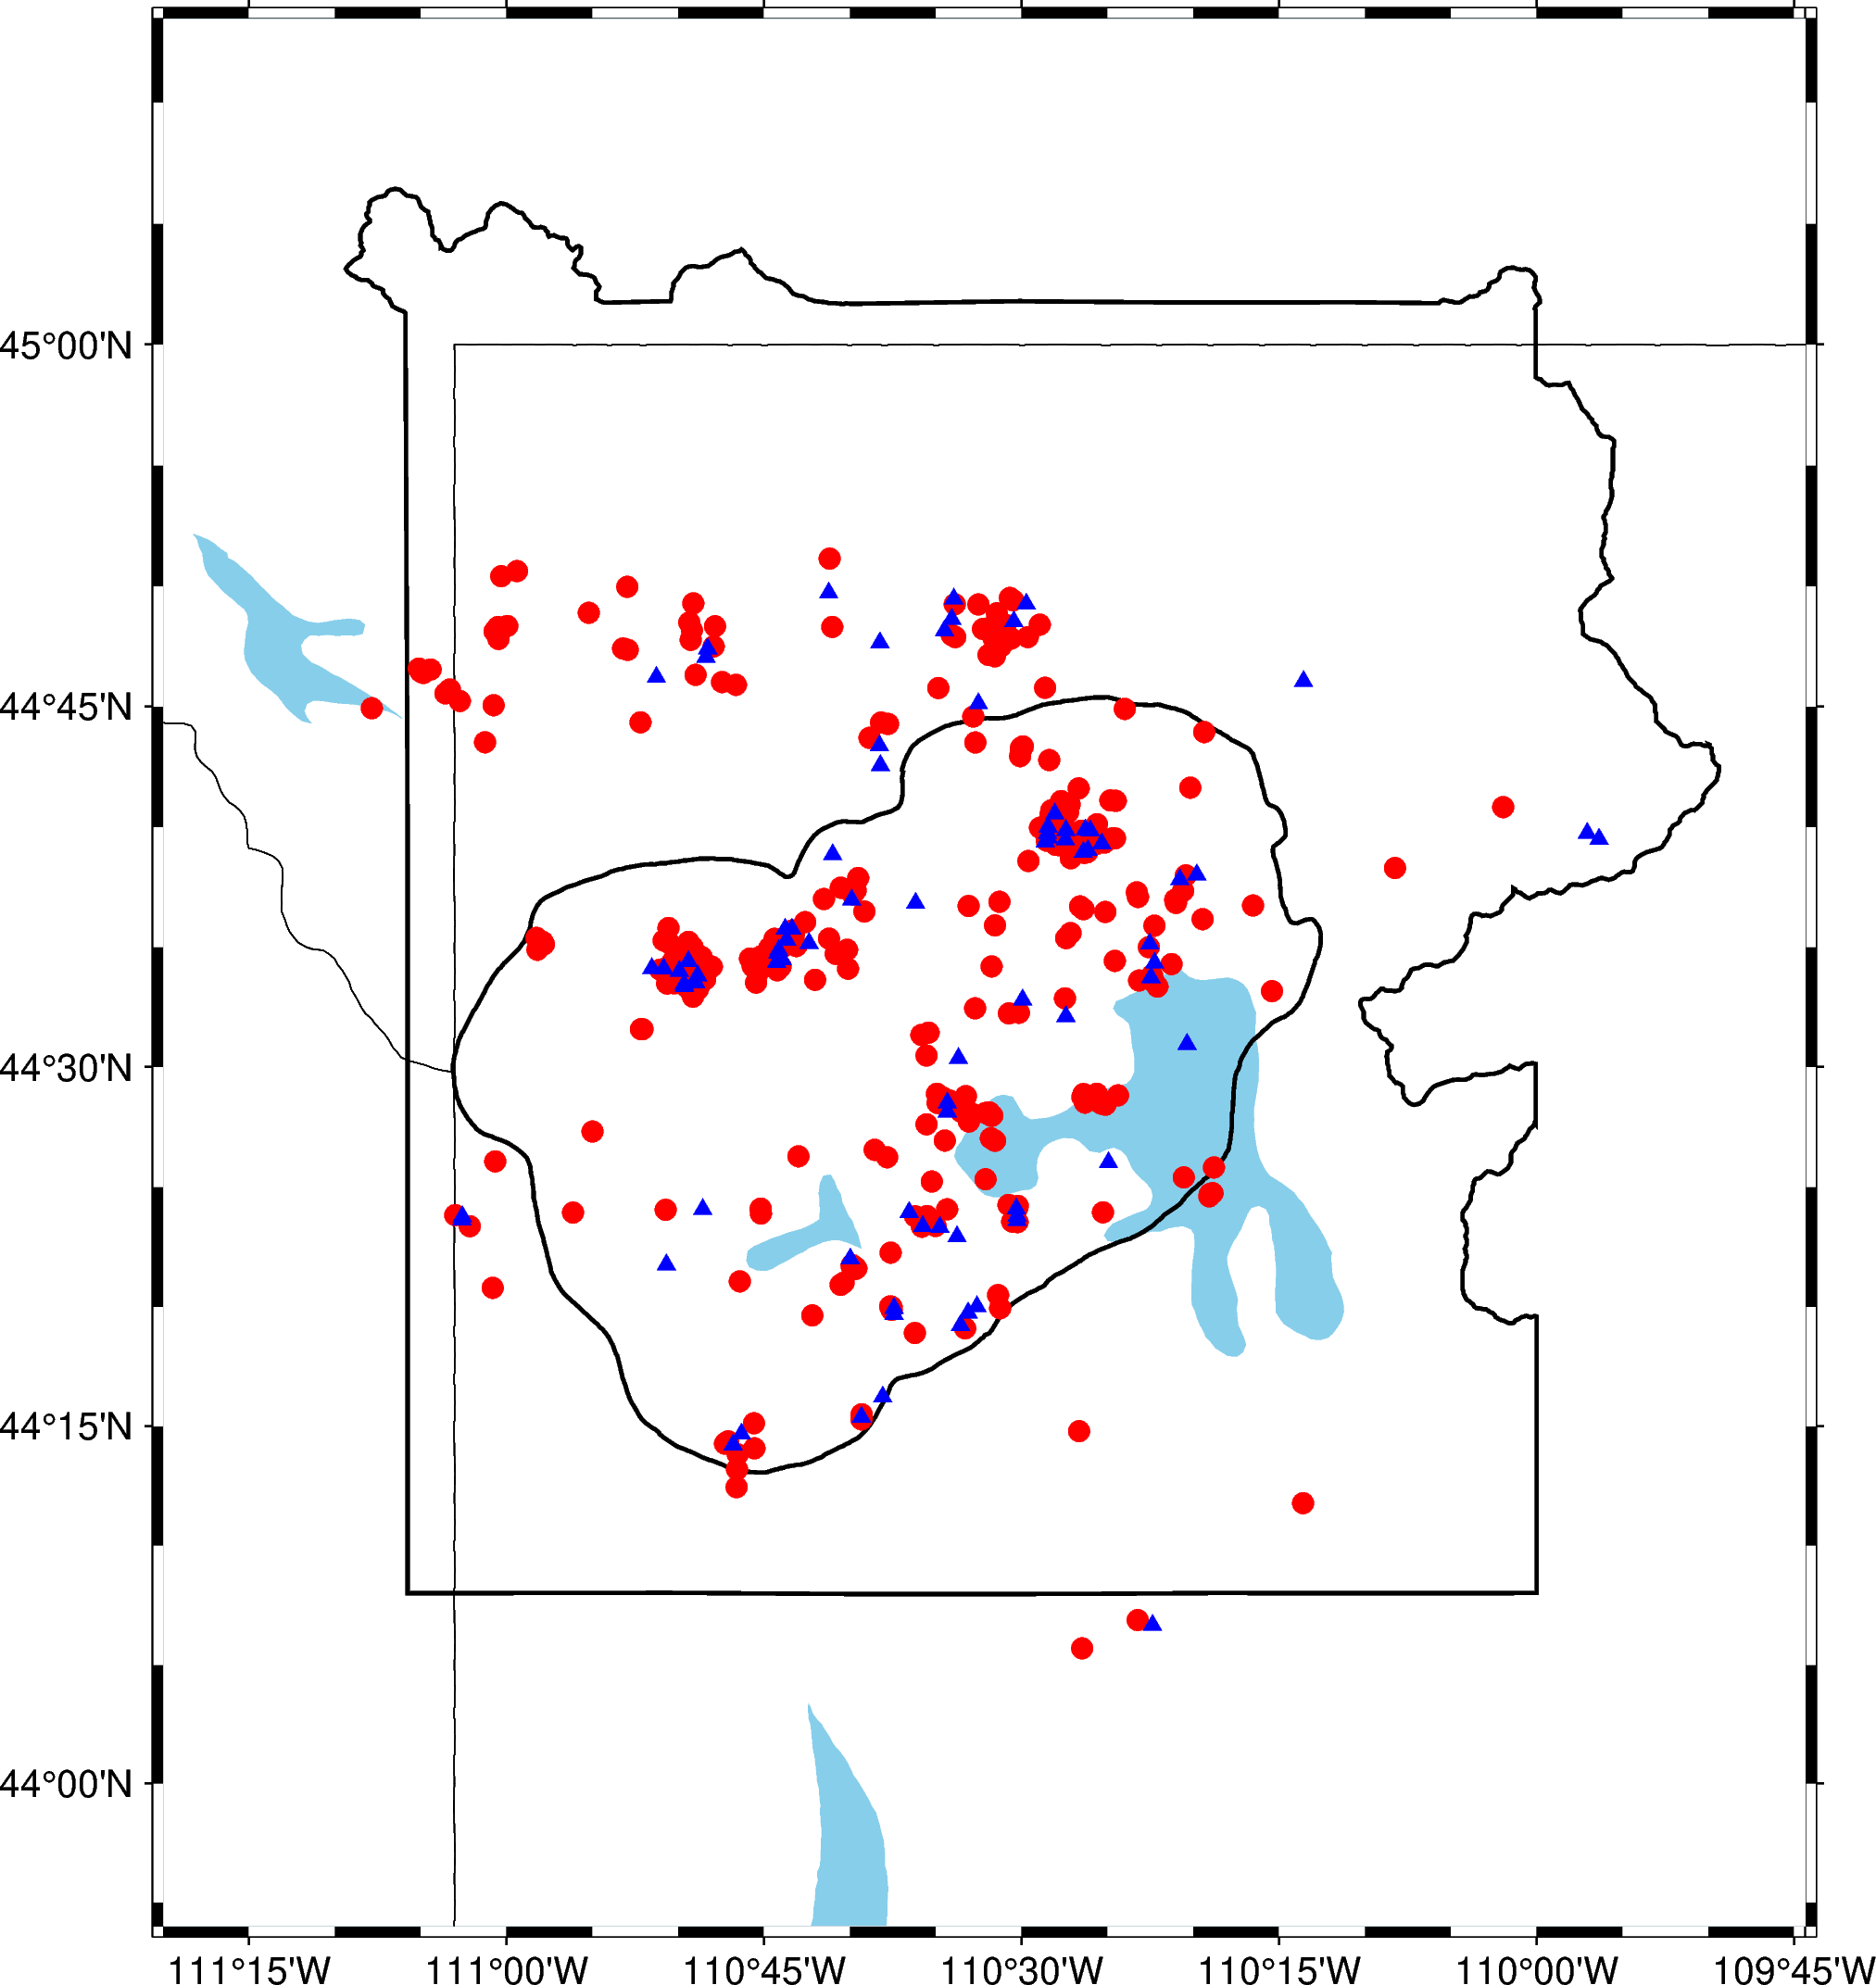

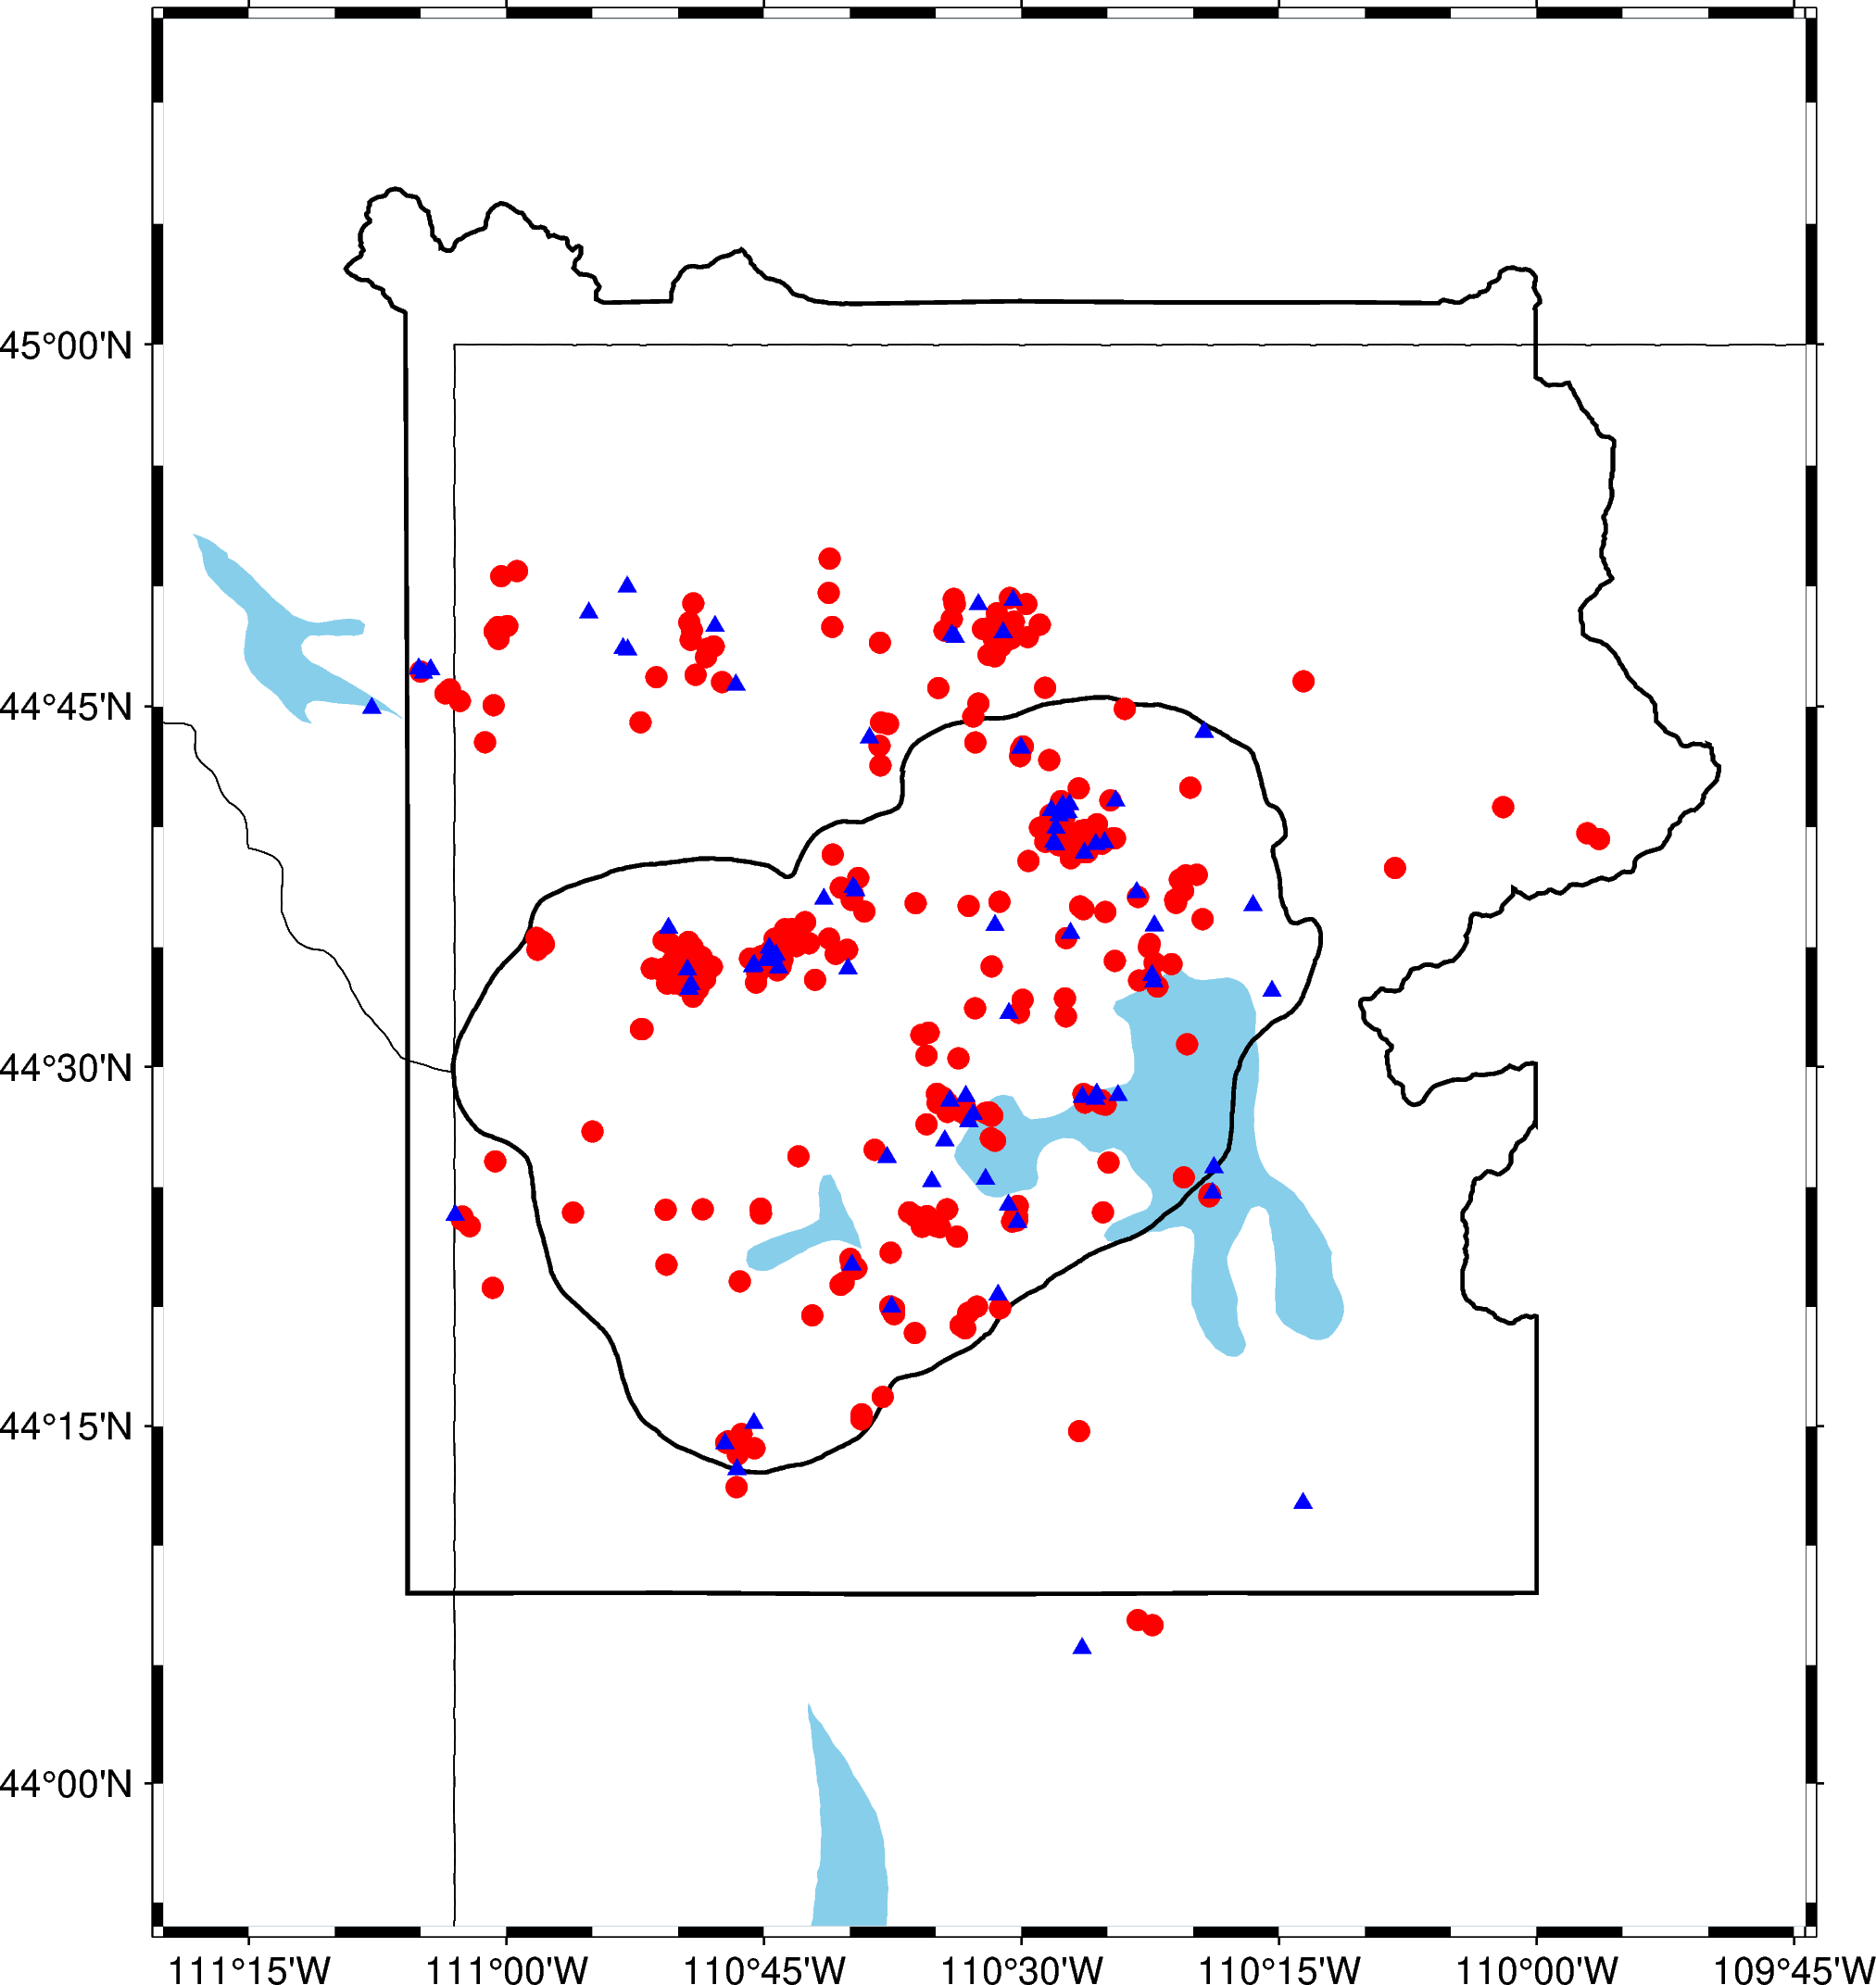

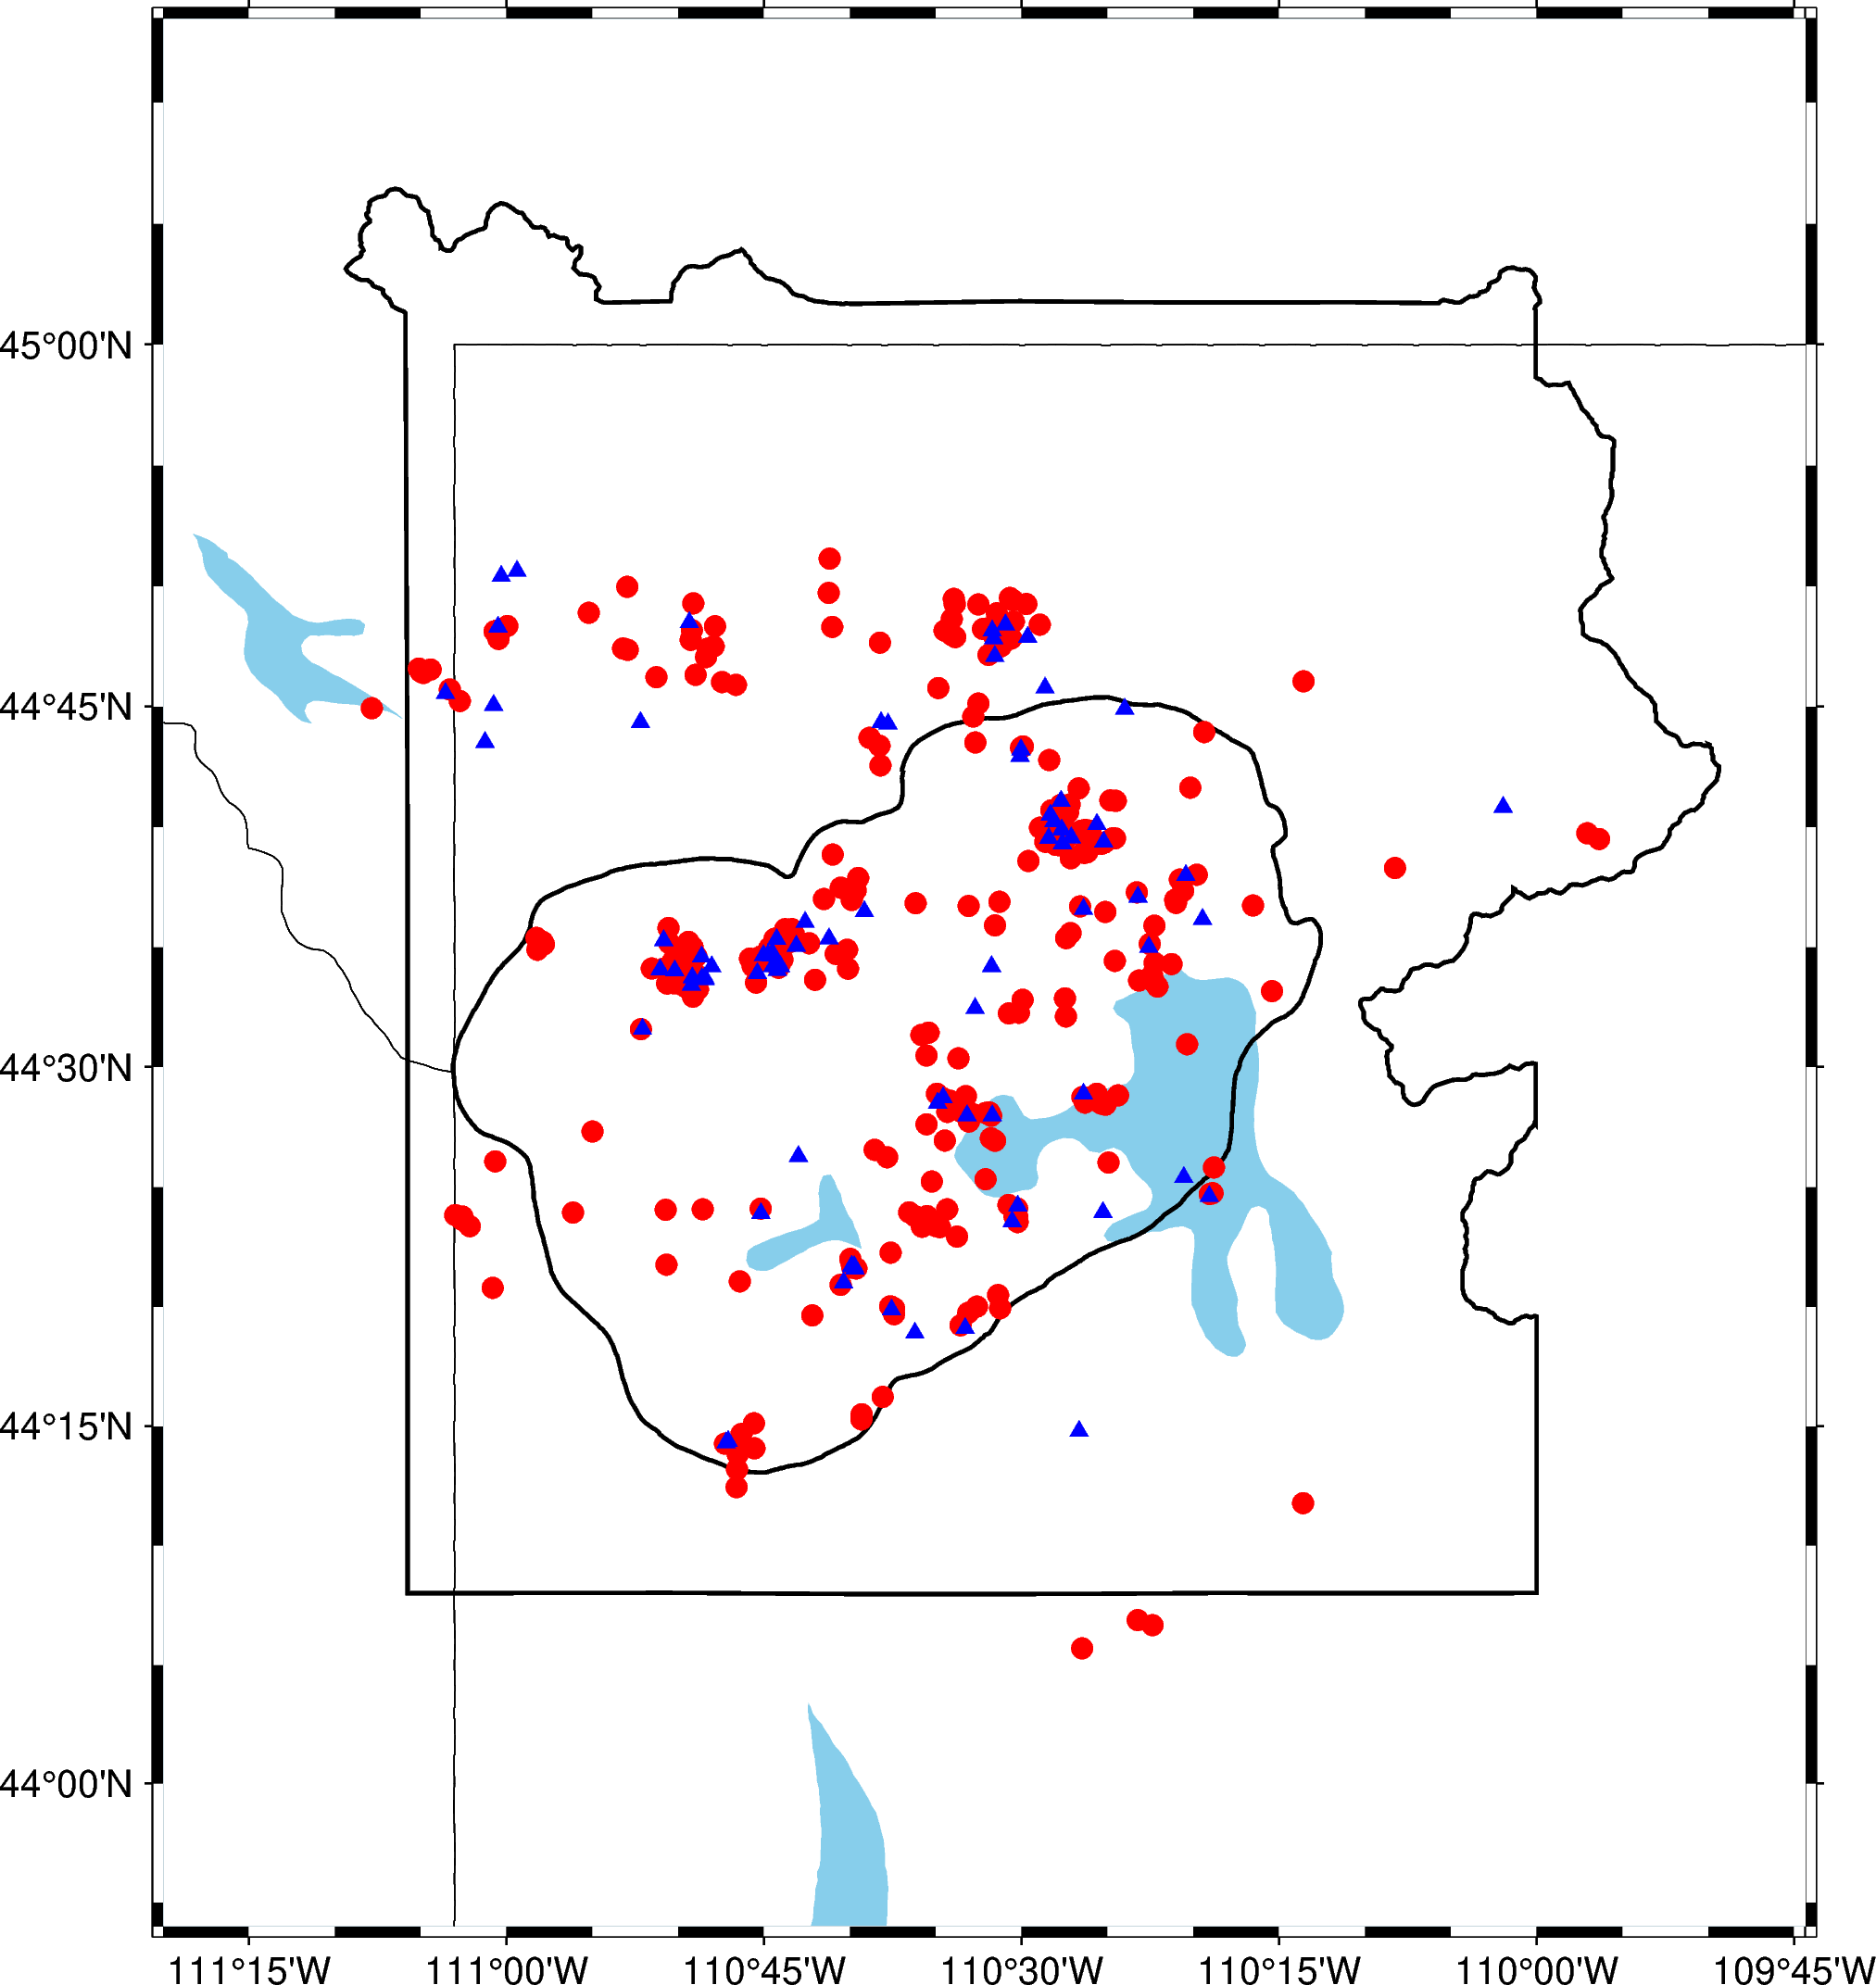

In [201]:
#Draw event map 
region = [
    eq_locs_df.event_lon.min() - 0.2,
    eq_locs_df.event_lon.max() + 0.2,
    eq_locs_df.event_lat.min() - 0.1,
    eq_locs_df.event_lat.max() + 0.2,
]

unique_locations = df_ngb_removed[["source_longitude", "source_latitude"]].drop_duplicates()
unique_ngb_locations = df_ngb[["source_longitude", "source_latitude"]].drop_duplicates()

for ind in range(len(folds)):

    fig = pygmt.Figure()
    fig.basemap(region=region, projection="M15c", frame=True)
    fig.coast(land="white", borders=2, water="skyblue")

    fig.plot(data=ys_border, pen="1.0p,black")
    fig.plot(data=caldera, pen='1.0p,black')

    train_subset = train_df.iloc[folds[ind][0]]
    test_subset = train_df.iloc[folds[ind][1]]
    fig.plot(x=train_subset.source_longitude, y=train_subset.source_latitude, style="c0.2c", color="red")
    fig.plot(x=test_subset.source_longitude, y=test_subset.source_latitude, style="t0.2c", color="blue")

    fig.show()

In [196]:
train_df.iloc[folds[0][0]]

,arrival_identifier,avg_noise_1.00,avg_noise_10.00,avg_noise_11.00,avg_noise_12.00,avg_noise_13.00,avg_noise_14.00,avg_noise_15.00,avg_noise_16.00,avg_noise_17.00,...,signal_dominant_frequency,signal_maximum_value,signal_minimum_value,signal_variance,source_depth_km,source_latitude,source_longitude,source_receiver_back_azimuth,source_receiver_distance_km,station
30656,5809,0.012736,0.000468,0.000409,0.000357,0.000309,0.000265,0.000226,0.000193,0.000166,...,1.0,1.222115,-1.181241,0.309350,12.42,44.393833,-111.043500,250.328137,54.320450,B208
30767,6454,0.010954,0.000196,0.000173,0.000149,0.000128,0.000112,0.000099,0.000089,0.000081,...,1.0,0.625372,-0.631372,0.103980,10.17,44.396000,-111.043000,250.552632,54.200636,B208
30819,11424,0.001676,0.000136,0.000124,0.000109,0.000098,0.000092,0.000088,0.000084,0.000079,...,2.0,0.318430,-0.315421,0.011966,6.16,44.270333,-110.634833,210.064693,37.186592,B208
30826,14129,0.012111,0.000712,0.000589,0.000484,0.000405,0.000352,0.000310,0.000273,0.000242,...,2.0,1.141995,-1.218255,0.207197,4.70,44.370833,-110.627333,220.577349,27.672190,B208
30840,15599,0.002697,0.000152,0.000129,0.000108,0.000094,0.000084,0.000077,0.000075,0.000076,...,1.0,0.371656,-0.257214,0.018363,16.44,44.397000,-111.050000,250.860977,54.687999,B208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50509,1252344,0.003892,0.001517,0.001395,0.001198,0.000995,0.000827,0.000691,0.000586,0.000509,...,16.0,3.049228,-3.968842,0.588696,2.09,44.654667,-110.428167,348.608209,10.708843,B208
50519,1252074,0.003087,0.000239,0.000197,0.000169,0.000159,0.000153,0.000146,0.000137,0.000127,...,9.0,0.163906,-0.092989,0.001511,11.38,44.820833,-110.495500,345.605313,29.906221,B208
50725,1270029,0.001574,0.000178,0.000158,0.000138,0.000120,0.000106,0.000099,0.000097,0.000095,...,2.0,0.072661,-0.058864,0.000608,3.83,44.362500,-110.845000,238.255831,41.573156,B208
50790,1270474,0.001822,0.000701,0.000720,0.000765,0.000797,0.000781,0.000725,0.000646,0.000561,...,3.0,0.220852,-0.276286,0.010425,11.00,44.748833,-111.131000,290.169787,61.542963,B208


In [24]:
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.metrics import r2_score

## RFE

from RFECV, know that most of the gain comes from 5-10 features. Use RFE to find 8 "best" features

In [25]:
train_feat_df.columns[:-1]

Index(['amp_ratio_01.0', 'amp_ratio_02.0', 'amp_ratio_03.0', 'amp_ratio_04.0',
       'amp_ratio_05.0', 'amp_ratio_06.0', 'amp_ratio_07.0', 'amp_ratio_08.0',
       'amp_ratio_09.0', 'amp_ratio_10.0', 'amp_ratio_11.0', 'amp_ratio_12.0',
       'amp_ratio_13.0', 'amp_ratio_14.0', 'amp_ratio_15.0', 'amp_ratio_16.0',
       'amp_ratio_17.0', 'amp_ratio_18.0', 'amp_01.0', 'amp_02.0', 'amp_03.0',
       'amp_04.0', 'amp_05.0', 'amp_06.0', 'amp_07.0', 'amp_08.0', 'amp_09.0',
       'amp_10.0', 'amp_11.0', 'amp_12.0', 'amp_13.0', 'amp_14.0', 'amp_15.0',
       'amp_16.0', 'amp_17.0', 'amp_18.0', 'signal_dominant_frequency',
       'signal_dominant_amplitude', 'noise_max_amplitude',
       'signal_max_amplitude', 'signal_variance', 'noise_variance',
       'source_receiver_distance_logkm', 'source_depth_km', 'source_latitude',
       'source_longitude', 'sin_receiver_back_azimuth'],
      dtype='object')

In [26]:
# Find best features for whole training dataset
estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=8, step=1)
selector = selector.fit(train_feat_matrix_scaled[:, :-1], train_y)

train_feat_df.columns[:-1][selector.support_]

Index(['amp_02.0', 'amp_04.0', 'amp_06.0', 'amp_07.0', 'amp_10.0', 'amp_12.0',
       'signal_variance', 'source_receiver_distance_logkm'],
      dtype='object')

In [27]:
# Sort features by importance - first 8 are in no particular order
train_feat_df.columns[:-1][np.argsort(selector.ranking_)]

Index(['amp_06.0', 'source_receiver_distance_logkm', 'signal_variance',
       'amp_10.0', 'amp_04.0', 'amp_02.0', 'amp_12.0', 'amp_07.0', 'amp_09.0',
       'source_latitude', 'signal_dominant_amplitude', 'amp_ratio_12.0',
       'amp_ratio_09.0', 'amp_ratio_16.0', 'amp_ratio_13.0', 'amp_ratio_15.0',
       'amp_ratio_18.0', 'amp_ratio_03.0', 'amp_ratio_14.0', 'amp_13.0',
       'amp_17.0', 'amp_08.0', 'noise_max_amplitude', 'amp_ratio_08.0',
       'amp_11.0', 'amp_03.0', 'amp_ratio_01.0', 'amp_ratio_17.0', 'amp_14.0',
       'amp_18.0', 'amp_05.0', 'amp_01.0', 'signal_max_amplitude',
       'amp_ratio_10.0', 'signal_dominant_frequency', 'source_longitude',
       'amp_15.0', 'source_depth_km', 'amp_16.0', 'amp_ratio_06.0',
       'amp_ratio_05.0', 'amp_ratio_07.0', 'amp_ratio_04.0', 'noise_variance',
       'amp_ratio_02.0', 'sin_receiver_back_azimuth', 'amp_ratio_11.0'],
      dtype='object')

In [28]:
# Training performace with these 8 features in the linear model 
r2_score(selector.predict(train_feat_matrix_scaled[:, :-1]), train_y)

0.5143746613565603

In [29]:
# CV performace with these 8 features in non-linear model
svr = SVR(C=1.0, epsilon=0.2)
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
cross_validate(pipeline, train_feat_matrix_unscaled[:, :-1][:, selector.support_], train_y, cv=folds, scoring="r2")

{'fit_time': array([0.00464606, 0.00314617, 0.00312161, 0.00331879, 0.00368285]),
 'score_time': array([0.0009222 , 0.0007925 , 0.00077558, 0.00120258, 0.00081635]),
 'test_score': array([0.74984688, 0.70625334, 0.66964256, 0.65429882, 0.69940108])}

In [30]:
# Get best RFE features for various folds and evaluate 
for fold in folds:
    # Pipeline for choosing features for fold
    estimator = SVR(kernel="linear")
    selector = RFE(estimator, n_features_to_select=8, step=1)
    pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('selector', selector)])
    
    # Fold data - exclude receiver_back_azimuth since linear model
    cv_train_X = train_feat_matrix_unscaled[fold[0], :-1]
    cv_train_y = train_y[fold[0]]
    cv_test_X = train_feat_matrix_unscaled[fold[1], :-1]
    cv_test_y = train_y[fold[1]]
    
    # Fit selector to fold training data
    s = pipeline.fit(cv_train_X, cv_train_y)
    # Make predictions on the fold test data
    preds = s.predict(cv_test_X)
    # Get the features for this model
    support = s.named_steps.selector.support_
    # Print the features
    print(train_feat_df.columns[:-1][support])
    # Print the test R^2 score
    print(r2_score(cv_test_y, preds))
    
    # Use this features in a non-linear model. Cross validate over all the folds
    svr = SVR(C=1.0, epsilon=0.2)
    nl_pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
    print(cross_validate(nl_pipeline, train_feat_matrix_unscaled[:, :-1][:, support],
                         train_y, cv=folds, scoring="r2")["test_score"])

Index(['amp_04.0', 'amp_05.0', 'amp_06.0', 'amp_07.0', 'amp_10.0', 'amp_12.0',
       'signal_variance', 'source_receiver_distance_logkm'],
      dtype='object')
0.7056501207672271
[0.74854379 0.68714694 0.65336043 0.59569672 0.68685325]
Index(['amp_02.0', 'amp_04.0', 'amp_05.0', 'amp_10.0', 'amp_12.0',
       'signal_max_amplitude', 'signal_variance',
       'source_receiver_distance_logkm'],
      dtype='object')
0.5916890337984648
[0.76346751 0.71388326 0.67002121 0.66130773 0.70435837]
Index(['amp_04.0', 'amp_05.0', 'amp_09.0', 'amp_10.0', 'amp_12.0',
       'signal_variance', 'source_receiver_distance_logkm', 'source_latitude'],
      dtype='object')
0.6712131679414122
[0.81355487 0.80670988 0.76680758 0.70428845 0.77803008]
Index(['amp_ratio_11.0', 'amp_02.0', 'amp_03.0', 'amp_10.0', 'amp_12.0',
       'signal_variance', 'source_receiver_distance_logkm', 'source_latitude'],
      dtype='object')
0.6548826913516126
[0.80495734 0.81184397 0.78084717 0.72336862 0.77333524]
Index(['a

## Sequential Feature Selection. 
Forward selection until change in score is less than 1e-4 or reach half of the features. Slightly better CV performace with 13 features than 46 for non-linear SVR. Pretty comparable performace between the 13 and 46 features in linear SVR. 

In [31]:
svr = SVR(C=1.0, epsilon=0.2)
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
sfs = SequentialFeatureSelector(pipeline, n_features_to_select="auto", tol=1e-3, scoring="r2", 
                                cv=folds, n_jobs=3).fit(train_feat_matrix_unscaled, train_y)

sfs.get_feature_names_out(train_feat_df.columns)

array(['amp_01.0', 'amp_02.0', 'amp_12.0', 'signal_variance',
       'source_receiver_distance_logkm', 'source_latitude',
       'source_longitude'], dtype=object)

In [32]:
svr = SVR(C=1.0, epsilon=0.2)
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
cross_validate(pipeline, train_feat_matrix_unscaled[:, sfs.get_support()], train_y, cv=folds)

{'fit_time': array([0.00410104, 0.00345111, 0.00337768, 0.0037818 , 0.00322771]),
 'score_time': array([0.00084114, 0.00075316, 0.0007627 , 0.00072241, 0.00069785]),
 'test_score': array([0.84029266, 0.84085736, 0.77791695, 0.7373395 , 0.78765805])}

In [33]:
svr = SVR(C=1.0, epsilon=0.2)
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
sfs = SequentialFeatureSelector(pipeline, n_features_to_select="auto", tol=1e-4, scoring="r2", 
                                cv=folds, n_jobs=3).fit(train_feat_matrix_unscaled, train_y)

sfs.get_feature_names_out(train_feat_df.columns)

array(['amp_ratio_05.0', 'amp_01.0', 'amp_02.0', 'amp_12.0', 'amp_18.0',
       'signal_dominant_amplitude', 'signal_max_amplitude',
       'signal_variance', 'source_receiver_distance_logkm',
       'source_latitude', 'source_longitude'], dtype=object)

In [34]:
svr = SVR(C=1.0, epsilon=0.2)
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
cross_validate(pipeline, train_feat_matrix_unscaled[:, sfs.get_support()], train_y, cv=folds)

{'fit_time': array([0.00380015, 0.00394106, 0.00382948, 0.00352287, 0.00343442]),
 'score_time': array([0.0008266 , 0.00077701, 0.00081062, 0.00084066, 0.0007844 ]),
 'test_score': array([0.85231683, 0.8318038 , 0.78419293, 0.74705664, 0.78679361])}

In [78]:
tmp_feats = ['amp_ratio_05.0', 'amp_01.0', 'amp_02.0', 'amp_12.0', 'amp_18.0',
       'signal_dominant_amplitude', 'signal_max_amplitude',
       'signal_variance',
       'source_latitude', 'source_longitude']
svr = SVR(C=1.0, epsilon=0.2)
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
cross_validate(pipeline, train_feat_df_unscaled[tmp_feats], train_y, cv=folds)

{'fit_time': array([0.00579453, 0.00549698, 0.00611877, 0.00554943, 0.00561547]),
 'score_time': array([0.00158906, 0.00163126, 0.00165033, 0.00170612, 0.00165486]),
 'test_score': array([0.83735579, 0.80339981, 0.77690996, 0.72592579, 0.79346798])}

In [35]:
# Result when selecting 6 features
# array(['amp_01.0', 'amp_02.0', 'amp_12.0', 'signal_dominant_amplitude',
#        'source_receiver_distance_logkm', 'source_longitude'], dtype=object)
# 0.86665783, 0.86072235, 0.83637506, 0.87239198, 0.87021598

In [36]:
# Performance when using all features
svr = SVR(C=1.0, epsilon=0.2)
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
cross_validate(pipeline, train_feat_matrix_unscaled, train_y, cv=folds)

{'fit_time': array([0.00424552, 0.00455427, 0.00419164, 0.00438428, 0.00465941]),
 'score_time': array([0.00101447, 0.00104189, 0.00099087, 0.00101304, 0.00100589]),
 'test_score': array([0.74094275, 0.76558213, 0.73389374, 0.6863152 , 0.75156792])}

# Go more in-depth into the effect of the more important features

In [47]:
all_selected_features = ['signal_dominant_amplitude', "signal_max_amplitude", "signal_variance", 
                         'source_longitude', "source_latitude", 'source_receiver_distance_logkm',
                         'source_depth_km', "receiver_back_azimuth", "amp_01.0", 
                         'amp_02.0', "amp_12.0", "amp_18.0", "amp_ratio_01.0","amp_ratio_05.0"]

selected_features_lat_lon = ['signal_dominant_amplitude', "signal_max_amplitude", "signal_variance", 
                         'source_longitude', "source_latitude",'source_depth_km', "amp_01.0", 
                         'amp_02.0', "amp_12.0", "amp_18.0", "amp_ratio_01.0","amp_ratio_05.0"]

selected_features_sr = ['signal_dominant_amplitude', "signal_max_amplitude", "signal_variance", 
                         'source_receiver_distance_logkm','source_depth_km', "receiver_back_azimuth", 
                        "amp_01.0",'amp_02.0', "amp_12.0", "amp_18.0", "amp_ratio_01.0","amp_ratio_05.0"]

In [48]:
def svr_cv(X, y, folds, C=1.0, epsilon=0.2):
    svr = SVR(C=C, epsilon=epsilon)
    pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
    cv_scores = cross_validate(pipeline, X, y, scoring="r2", cv=folds)["test_score"]
    
    return cv_scores

In [49]:
def seq_feature_importance(selected_features, train_feat_df_unscaled):
    feat_selection = np.copy(selected_features)
    best_features = []
    r2_maxs = []
    r2_mins = []
    r2_means = []

    for it in range(len(selected_features)):
        print("iteration", it)
        print(best_features)

        it_r2_vals = []
    #     best_feat_ind = -1

        for feature_ind in range(len(feat_selection)):
            features = [feat_selection[feature_ind]]
            if len(best_features) == 0:
                train_X = train_feat_df_unscaled[features].values.reshape(-1, 1)
            else:
                features = np.concatenate([best_features, features])
                train_X = train_feat_df_unscaled[features].values

            cv_scores = svr_cv(train_X, train_y, folds)

            mean_cv = np.mean(cv_scores)
            print(features[-1], mean_cv)
    #         if mean_cv > max_r2:
    #             best_feat_ind = feature_ind
    #             max_r2 = mean_cv

            it_r2_vals.append(mean_cv)

        best_feat_ind = np.argmax(it_r2_vals)
        best_features.append(feat_selection[best_feat_ind])
        r2_means.append(np.mean(it_r2_vals))
        r2_mins.append(np.min(it_r2_vals))
        r2_maxs.append(np.max(it_r2_vals))

        feat_selection = np.delete(feat_selection, best_feat_ind)

    n_features = np.arange(1, len(selected_features)+1)
    plt.plot(n_features, r2_means, linestyle="--", color="k", label="mean")
    plt.plot(n_features, r2_mins, color="k", label="min")
    plt.fill_between(n_features, r2_maxs, r2_mins, color="gray")
    plt.plot(n_features, r2_maxs, marker="x", color="r", label="max")
    plt.xticks(n_features) #, labels=n_features[::-1]) #, labels=best_features, rotation=45);
    plt.grid()
    plt.xlabel("N Features") #("N Features to Choose From");
    plt.ylabel(r"Mean $R^2$ of 5-fold CV");
    plt.legend();
    
    return best_features

iteration 0
[]
signal_dominant_amplitude 0.05747161455026619
signal_max_amplitude 0.05099426807287435
signal_variance 0.053281172890568815
source_longitude 0.12299752284267162
source_latitude 0.032327802308537844
source_depth_km 0.03177324137925854
amp_01.0 0.2584899849932939
amp_02.0 0.18902091295419984
amp_12.0 0.0077514803267334734
amp_18.0 0.013086570903305983
amp_ratio_01.0 0.10296459848392318
amp_ratio_05.0 0.051483797088306284
iteration 1
['amp_01.0']
signal_dominant_amplitude 0.3204295090896049
signal_max_amplitude 0.342465368603067
signal_variance 0.33273035399490186
source_longitude 0.5404367532879748
source_latitude 0.5180347168432348
source_depth_km 0.3204032349789957
amp_02.0 0.27504378719740463
amp_12.0 0.3341955160615707
amp_18.0 0.3592853206782043
amp_ratio_01.0 0.30113908933259903
amp_ratio_05.0 0.2596398063004762
iteration 2
['amp_01.0', 'source_longitude']
signal_dominant_amplitude 0.5658521662736483
signal_max_amplitude 0.5618702876300097
signal_variance 0.564028608

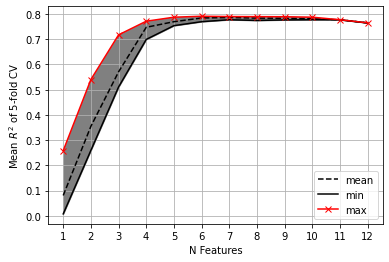

In [50]:
best_features_lat_lon = seq_feature_importance(selected_features_lat_lon, train_feat_df_unscaled)

In [51]:
# Best features when including lat, lon, and source_receiver_distance_logkm. Do not include receiver_back_azimith
# ['amp_01.0',
#  'source_longitude',
#  'amp_12.0',
#  'source_receiver_distance_logkm',
#  'amp_02.0',
#  'signal_dominant_amplitude',
#  'amp_ratio_01.0',
#  'source_latitude',
#  'amp_08.0',
#  'amp_18.0',
#  'source_depth_km',
#  'signal_max_amplitude',
#  'signal_variance']

In [52]:
best_features_lat_lon

['amp_01.0',
 'source_longitude',
 'source_latitude',
 'signal_variance',
 'amp_02.0',
 'amp_18.0',
 'amp_ratio_05.0',
 'signal_max_amplitude',
 'signal_dominant_amplitude',
 'amp_12.0',
 'amp_ratio_01.0',
 'source_depth_km']

iteration 0
[]
signal_dominant_amplitude 0.05747161455026619
signal_max_amplitude 0.05099426807287435
signal_variance 0.053281172890568815
source_receiver_distance_logkm 0.16943855256429247
source_depth_km 0.03177324137925854
receiver_back_azimuth -0.027528371130667927
amp_01.0 0.2584899849932939
amp_02.0 0.18902091295419984
amp_12.0 0.0077514803267334734
amp_18.0 0.013086570903305983
amp_ratio_01.0 0.10296459848392318
amp_ratio_05.0 0.051483797088306284
iteration 1
['amp_01.0']
signal_dominant_amplitude 0.3204295090896049
signal_max_amplitude 0.342465368603067
signal_variance 0.33273035399490186
source_receiver_distance_logkm 0.636439203127205
source_depth_km 0.3204032349789957
receiver_back_azimuth 0.3581501613581534
amp_02.0 0.27504378719740463
amp_12.0 0.3341955160615707
amp_18.0 0.3592853206782043
amp_ratio_01.0 0.30113908933259903
amp_ratio_05.0 0.2596398063004762
iteration 2
['amp_01.0', 'source_receiver_distance_logkm']
signal_dominant_amplitude 0.6979949741807198
signal_max_am

['amp_01.0',
 'source_receiver_distance_logkm',
 'signal_dominant_amplitude',
 'receiver_back_azimuth',
 'amp_18.0',
 'amp_02.0',
 'amp_ratio_05.0',
 'signal_max_amplitude',
 'signal_variance',
 'amp_12.0',
 'amp_ratio_01.0',
 'source_depth_km']

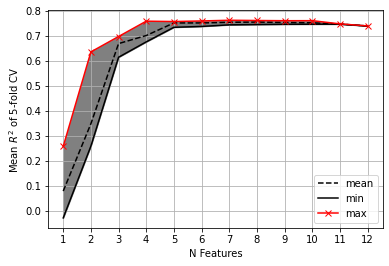

In [53]:
best_features_sr = seq_feature_importance(selected_features_sr, train_feat_df_unscaled)
best_features_sr

In [54]:
# All selected features with lat lon result
selected_feat_lat_lon_cv = svr_cv(train_feat_df_unscaled[selected_features_lat_lon], train_y, folds)
print(selected_feat_lat_lon_cv)
print(np.mean(selected_feat_lat_lon_cv))

[0.76367122 0.80595787 0.74700143 0.7189451  0.78918393]
0.7649519108444068


In [57]:
# Top 5 features with lat lon 
top_feat_lat_lon_cv = svr_cv(train_feat_df_unscaled[best_features_lat_lon[0:6]], train_y, folds)
print(top_feat_lat_lon_cv )
print(np.mean(top_feat_lat_lon_cv))

[0.83114154 0.82873654 0.76869146 0.72428408 0.80285998]
0.7911427224413509


In [58]:
# All selected features with sr distance and back azimuth
selected_feat_sr_cv = svr_cv(train_feat_df_unscaled[selected_features_sr], train_y, folds)
print(selected_feat_sr_cv)
print(np.mean(selected_feat_sr_cv))

[0.75339199 0.78415758 0.70141378 0.71358455 0.74850374]
0.7402103275729486


In [85]:
# Top 5 selected features with sr distance and back azimuth
top_feat_sr_cv = svr_cv(train_feat_df_unscaled[best_features_sr[0:8]], train_y, folds)
print(top_feat_sr_cv )
print(np.mean(top_feat_sr_cv))

[0.81154808 0.79826168 0.75028549 0.7005768  0.74951741]
0.7620378948553952


In [79]:
selected_feat_df = train_feat_df.copy()[all_selected_features]
selected_feat_df.loc[:, "magnitude"] = train_y
corr = selected_feat_df.corr()
corr.style.background_gradient(cmap="coolwarm")

,signal_dominant_amplitude,signal_max_amplitude,signal_variance,source_longitude,source_latitude,source_receiver_distance_logkm,source_depth_km,receiver_back_azimuth,amp_01.0,amp_02.0,amp_12.0,amp_18.0,amp_ratio_01.0,amp_ratio_05.0,magnitude
signal_dominant_amplitude,1.000000,0.992017,0.993361,0.520332,-0.179576,-0.735749,-0.161908,-0.357913,0.825332,0.924547,0.966218,0.939783,0.172963,0.735159,0.348838
signal_max_amplitude,0.992017,1.000000,0.994805,0.546124,-0.134740,-0.774636,-0.183924,-0.332068,0.802559,0.905113,0.981856,0.966064,0.155257,0.732753,0.306648
signal_variance,0.993361,0.994805,1.000000,0.523975,-0.153419,-0.752397,-0.169402,-0.353038,0.833022,0.930188,0.979453,0.955578,0.168495,0.735623,0.341372
source_longitude,0.520332,0.546124,0.523975,1.000000,-0.028696,-0.710736,-0.370693,-0.324679,0.244921,0.406541,0.539917,0.596597,-0.165460,0.403607,-0.193202
source_latitude,-0.179576,-0.134740,-0.153419,-0.028696,1.000000,-0.029787,0.090964,0.461748,-0.138278,-0.185126,-0.113261,-0.038890,0.067368,-0.125305,0.039468
source_receiver_distance_logkm,-0.735749,-0.774636,-0.752397,-0.710736,-0.029787,1.000000,0.378046,0.263778,-0.456249,-0.591922,-0.783676,-0.824727,0.042674,-0.521611,0.209883
source_depth_km,-0.161908,-0.183924,-0.169402,-0.370693,0.090964,0.378046,1.000000,0.044864,-0.015659,-0.136338,-0.193252,-0.225192,0.264793,-0.090111,0.246258
receiver_back_azimuth,-0.357913,-0.332068,-0.353038,-0.324679,0.461748,0.263778,0.044864,1.000000,-0.312568,-0.358730,-0.315834,-0.268308,-0.053096,-0.281326,-0.028123
amp_01.0,0.825332,0.802559,0.833022,0.244921,-0.138278,-0.456249,-0.015659,-0.312568,1.000000,0.910379,0.758565,0.699215,0.397856,0.605516,0.529471
amp_02.0,0.924547,0.905113,0.930188,0.406541,-0.185126,-0.591922,-0.136338,-0.358730,0.910379,1.000000,0.872701,0.827080,0.213457,0.683131,0.483902


In [86]:
def add_feat_to_base(base_features, additional_features, all_features_cv=None, top_features_cv=None):

    cv_means = []

    for cf in additional_features:
        feat_list = base_features.copy()
        feat_list.append(cf)
        cv_vals = svr_cv(train_feat_df_unscaled[feat_list], train_y, folds)
        cv_means.append(np.mean(cv_vals))

    plt.scatter(range(len(additional_features)), cv_means, marker="x")
    plt.xticks(range(len(additional_features)), labels=additional_features, rotation=45);
    if all_features_cv is not None:
        plt.axhline(np.mean(all_features_cv))
    if top_features_cv is not None:
        plt.axhline(np.mean(top_features_cv), color="C1")
    plt.show()
    
    return cv_means

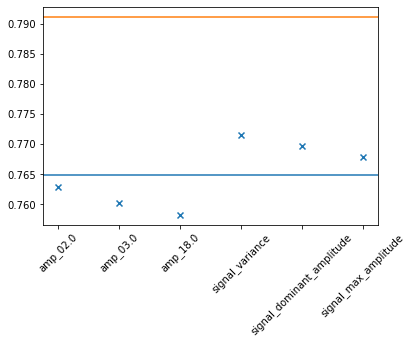

In [119]:
base_features = ['source_longitude', "source_latitude", "amp_01.0"]

correlated_features = [ 'amp_02.0', "amp_03.0", "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude"]

cv_means_nodepth_noampr1 = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_lat_lon_cv, 
                           top_features_cv=top_feat_lat_lon_cv)

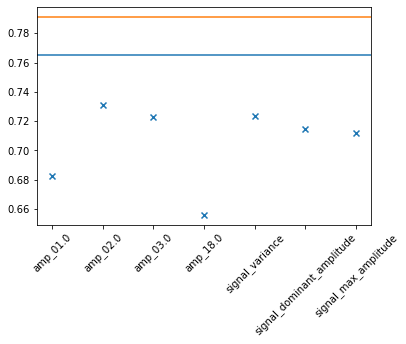

In [89]:
base_features = ['source_longitude', "source_latitude",'source_depth_km', 'amp_ratio_01.0']

correlated_features = ["amp_01.0", 'amp_02.0', "amp_03.0", "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude"]

cv_means = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_lat_lon_cv, 
                           top_features_cv=top_feat_lat_lon_cv)

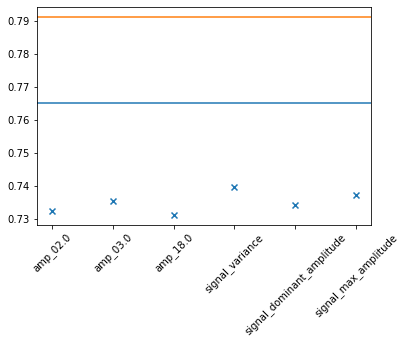

In [90]:
base_features = ['source_longitude', "source_latitude",'source_depth_km', 'amp_ratio_01.0', "amp_01.0"]

correlated_features = ['amp_02.0', "amp_03.0", "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude"]

cv_means_amp01  = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_lat_lon_cv, 
                           top_features_cv=top_feat_lat_lon_cv)

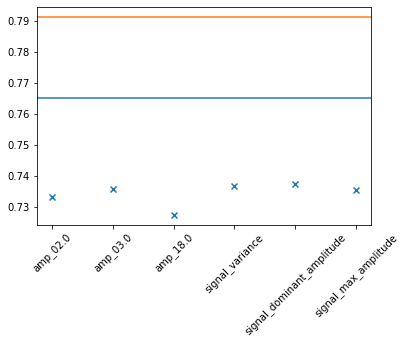

In [91]:
base_features = ['source_longitude', "source_latitude",'source_depth_km', 'amp_ratio_01.0', "amp_01.0", "amp_ratio_05.0"]

correlated_features = ['amp_02.0', "amp_03.0", "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude"]

cv_means_amp01_ampr05  = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_lat_lon_cv, 
                           top_features_cv=top_feat_lat_lon_cv)

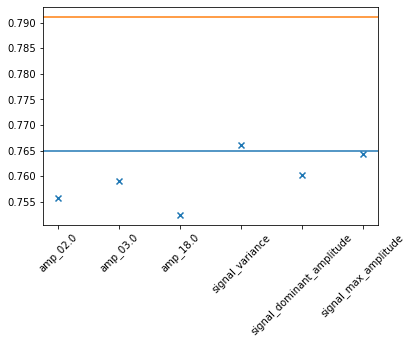

In [92]:
base_features = ['source_longitude', "source_latitude",'amp_ratio_01.0', "amp_01.0"]

correlated_features = ['amp_02.0', "amp_03.0", "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude"]

cv_means_nodepth = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_lat_lon_cv, 
                           top_features_cv=top_feat_lat_lon_cv)

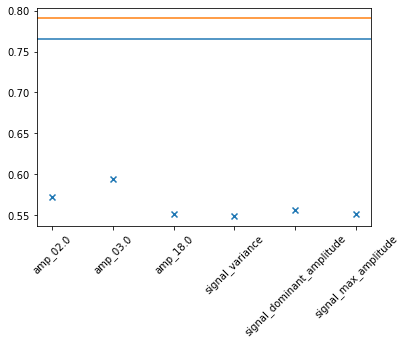

In [94]:
base_features = ['source_longitude','amp_ratio_01.0', "amp_01.0"]

correlated_features = ['amp_02.0', "amp_03.0","amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude"]

cv_means_nodepth_nolat = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_lat_lon_cv, 
                           top_features_cv=top_feat_lat_lon_cv)

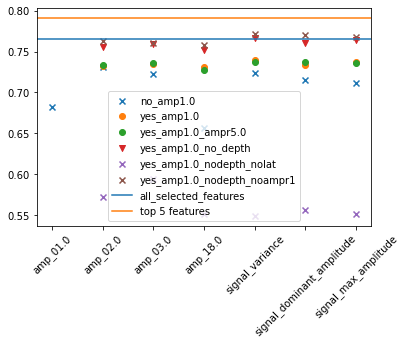

In [120]:
correlated_features = ["amp_01.0", 'amp_02.0',"amp_03.0", "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude"]

plt.scatter( range(0,len(correlated_features)), cv_means, marker="x", label="no_amp1.0")
plt.scatter( range(1,len(correlated_features)), cv_means_amp01, marker="o", label="yes_amp1.0")
plt.scatter( range(1,len(correlated_features)), cv_means_amp01_ampr05, marker="o", label="yes_amp1.0_ampr5.0")
plt.scatter( range(1,len(correlated_features)), cv_means_nodepth, marker="v", label="yes_amp1.0_no_depth")
plt.scatter( range(1,len(correlated_features)), cv_means_nodepth_nolat, marker="x", label="yes_amp1.0_nodepth_nolat")
plt.scatter( range(1,len(correlated_features)), cv_means_nodepth_noampr1, marker="x", label="yes_amp1.0_nodepth_noampr1")

plt.xticks(range(len(correlated_features)), labels=correlated_features, rotation=45);
plt.axhline(np.mean(selected_feat_lat_lon_cv), label="all_selected_features")
plt.axhline(np.mean(top_feat_lat_lon_cv), color="C1", label="top 5 features")
plt.legend();

In [308]:
fewer_features_lat_lon = ['source_longitude', "source_latitude", 
                          "signal_variance","amp_02.0", "amp_18.0"]
fewer_feat_lat_lon_df = train_feat_df.copy()[fewer_features_lat_lon]
fewer_feat_lat_lon_df.loc[:, "magnitude"] = train_y
corr = fewer_feat_lat_lon_df.corr()
corr.style.background_gradient(cmap="coolwarm")

,source_longitude,source_latitude,signal_variance,amp_02.0,amp_18.0,magnitude
source_longitude,1.000000,-0.028696,0.523975,0.406541,0.596597,-0.193202
source_latitude,-0.028696,1.000000,-0.153419,-0.185126,-0.038890,0.039468
signal_variance,0.523975,-0.153419,1.000000,0.930188,0.955578,0.341372
amp_02.0,0.406541,-0.185126,0.930188,1.000000,0.827080,0.483902
amp_18.0,0.596597,-0.038890,0.955578,0.827080,1.000000,0.204048
magnitude,-0.193202,0.039468,0.341372,0.483902,0.204048,1.000000


In [309]:
fewer_feat_lat_lon_cv = svr_cv(train_feat_df_unscaled[fewer_features_lat_lon], train_y, folds)
print(fewer_feat_lat_lon_cv)
print(np.mean(fewer_feat_lat_lon_cv))

[0.83354674 0.82818521 0.79202019 0.74521763 0.78937794]
0.7976695421835889


## Closer look at features with sr features

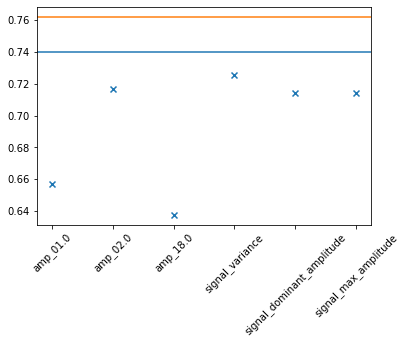

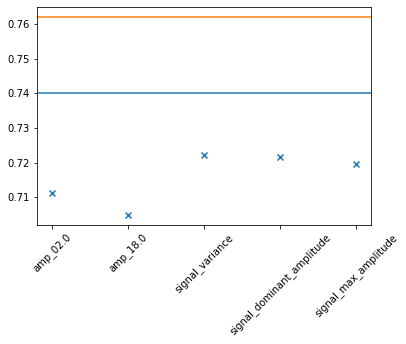

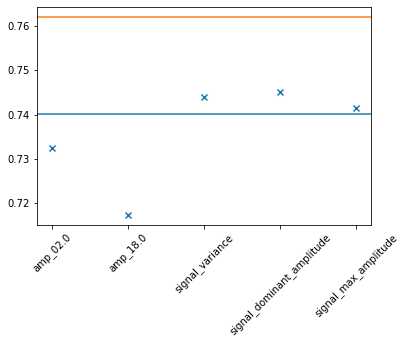

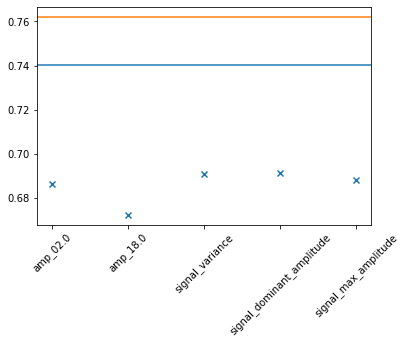

In [157]:
base_features = ['source_receiver_distance_logkm','source_depth_km', "receiver_back_azimuth", 'amp_ratio_01.0']

correlated_features = ["amp_01.0", 'amp_02.0',"amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude"]

cv_means = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
                           top_features_cv=top_feat_sr_cv)

base_features = ['source_receiver_distance_logkm','source_depth_km', "receiver_back_azimuth", 
                 'amp_ratio_01.0', "amp_01.0"]

correlated_features = ['amp_02.0', "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude"]
cv_means_amp01  = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
                           top_features_cv=top_feat_sr_cv)

base_features = ['source_receiver_distance_logkm', "receiver_back_azimuth",'amp_ratio_01.0', "amp_01.0"]

correlated_features = ['amp_02.0', "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude"]

cv_means_nodepth = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
                           top_features_cv=top_feat_sr_cv)

base_features = ['source_receiver_distance_logkm','amp_ratio_01.0', "amp_01.0"]

correlated_features = ['amp_02.0', "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude"]

cv_means_nodepth_noba = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
                           top_features_cv=top_feat_sr_cv)

# SR distance is important 
# base_features = ["receiver_back_azimuth",'amp_ratio_01.0', "amp_01.0"]

# correlated_features = ['amp_02.0', "amp_08.0", "amp_12.0", "amp_18.0", "signal_variance", 
#                        "signal_dominant_amplitude", "signal_max_amplitude"]

# cv_means_nodepth_nosrd = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
#                            top_features_cv=top_feat_sr_cv)

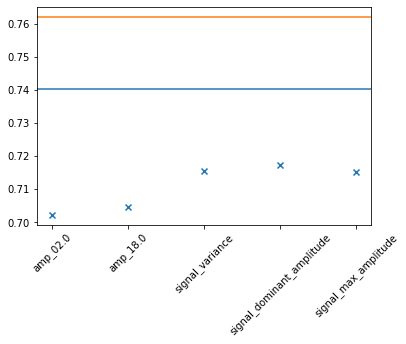

In [158]:
base_features = ['source_receiver_distance_logkm', "receiver_back_azimuth",'source_depth_km', 'amp_ratio_01.0', 
                 "amp_01.0", "amp_ratio_05.0"]

correlated_features = ['amp_02.0', "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude"]

cv_means_amp01_ampr05  = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
                           top_features_cv=top_feat_sr_cv)

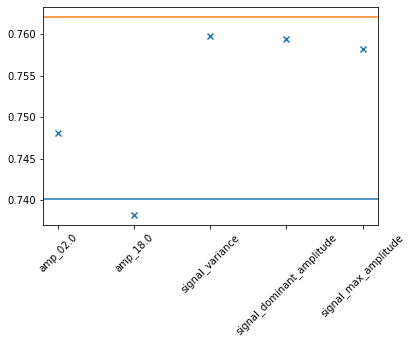

In [169]:
base_features = ['source_receiver_distance_logkm', "receiver_back_azimuth", "amp_01.0"]

correlated_features = ['amp_02.0', "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude"]

cv_means_simp1  = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
                           top_features_cv=top_feat_sr_cv)

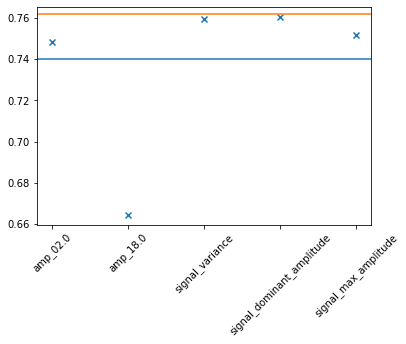

In [170]:
base_features = ['source_receiver_distance_logkm', "receiver_back_azimuth"]

correlated_features = ['amp_02.0', "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude"]

cv_means_simp  = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
                           top_features_cv=top_feat_sr_cv)

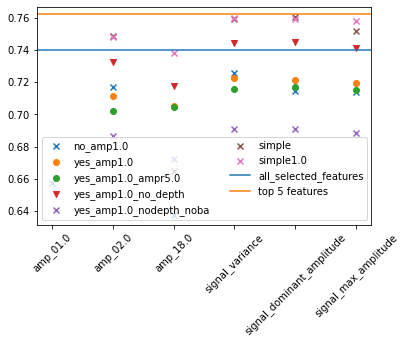

In [171]:
correlated_features = ["amp_01.0", 'amp_02.0', "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude"]

plt.scatter( range(0,len(correlated_features)), cv_means, marker="x", label="no_amp1.0")
plt.scatter( range(1,len(correlated_features)), cv_means_amp01, marker="o", label="yes_amp1.0")
plt.scatter( range(1,len(correlated_features)), cv_means_amp01_ampr05, marker="o", label="yes_amp1.0_ampr5.0")
plt.scatter( range(1,len(correlated_features)), cv_means_nodepth, marker="v", label="yes_amp1.0_no_depth")
plt.scatter( range(1,len(correlated_features)), cv_means_nodepth_noba, marker="x", label="yes_amp1.0_nodepth_noba")
plt.scatter( range(1,len(correlated_features)), cv_means_simp, marker="x", label="simple")
plt.scatter( range(1,len(correlated_features)), cv_means_simp1, marker="x", label="simple1.0")

# plt.scatter( range(1,len(correlated_features)), cv_means_nodepth_nosrd, marker="x", label="yes_amp1.0_nodepth_nosr")

plt.xticks(range(len(correlated_features)), labels=correlated_features, rotation=45);
plt.axhline(np.mean(selected_feat_sr_cv), label="all_selected_features")
plt.axhline(np.mean(top_feat_sr_cv), color="C1", label="top 5 features")
plt.legend(ncol=2);

In [306]:
fewer_features_sr = ['source_receiver_distance_logkm', "receiver_back_azimuth", "signal_variance","amp_02.0"]
fewer_feat_sr_df = train_feat_df.copy()[fewer_features_sr]
fewer_feat_sr_df.loc[:, "magnitude"] = train_y
corr = fewer_feat_sr_df.corr()
corr.style.background_gradient(cmap="coolwarm")

,source_receiver_distance_logkm,receiver_back_azimuth,signal_variance,amp_02.0,magnitude
source_receiver_distance_logkm,1.000000,0.263778,-0.752397,-0.591922,0.209883
receiver_back_azimuth,0.263778,1.000000,-0.353038,-0.358730,-0.028123
signal_variance,-0.752397,-0.353038,1.000000,0.930188,0.341372
amp_02.0,-0.591922,-0.358730,0.930188,1.000000,0.483902
magnitude,0.209883,-0.028123,0.341372,0.483902,1.000000


In [307]:
fewer_feat_sr_cv = svr_cv(train_feat_df_unscaled[fewer_features_sr], train_y, folds)
print(fewer_feat_sr_cv)
print(np.mean(fewer_feat_sr_cv))

[0.82261263 0.78298046 0.76312253 0.71394633 0.76284696]
0.7691017825701492
